Experiment 1

In [1]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
import os
import re
import string

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as k


2025-07-31 23:00:03.607527: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-31 23:00:03.616347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754020803.626879    8679 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754020803.630159    8679 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-31 23:00:03.642201: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)
text_only_dataset_all=dataset_all.map(lambda x, y: x)
categories =dict(enumerate(info.features["label"].names))
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")
nltk.download('stopwords',quiet=True)
STOPWORDS = stopwords.words("english")

max_tokens = None
text_vectorization=layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_dataset_all)


doc_sizes = []
corpus = []
for example, _ in dataset_all.as_numpy_iterator():
  enc_example = text_vectorization(example)
  doc_sizes.append(len(enc_example))
  corpus+=list(enc_example.numpy())

I0000 00:00:1754020804.755193    8679 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12483 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-07-31 23:00:06.825921: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-07-31 23:00:16.736802: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-07-31 23:12:29.841709: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
print(f"There are {len(corpus)} words in the corpus of {len(doc_sizes)} news articles.")
print(f"Each news article has between {min(doc_sizes)} and {max(doc_sizes)} tokens in it.")

There are 2579419 words in the corpus of 127600 news articles.
Each news article has between 2 and 95 tokens in it.


In [4]:
print(f"There are {len(text_vectorization.get_vocabulary())} vocabulary words in the corpus.")

There are 95827 vocabulary words in the corpus.


In [5]:
vocab = np.array(text_vectorization.get_vocabulary())
print(vocab[:50])

['' '[UNK]' '39s' 'said' 'new' 'us' 'reuters' 'ap' 'two' 'first' 'monday'
 'wednesday' 'tuesday' 'thursday' 'company' 'friday' 'inc' 'one' 'world'
 'yesterday' 'last' 'york' 'year' 'president' 'million' 'oil' 'corp'
 'united' 'would' 'sunday' 'years' 'week' 'people' 'today' 'three'
 'government' 'could' 'quot' 'group' 'time' 'percent' 'game' 'saturday'
 'software' 'night' 'next' 'prices' 'iraq' 'security' 'announced']


In [6]:
tfds.as_dataframe(dataset_all.take(10),info)

2025-07-31 23:25:11.942272: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


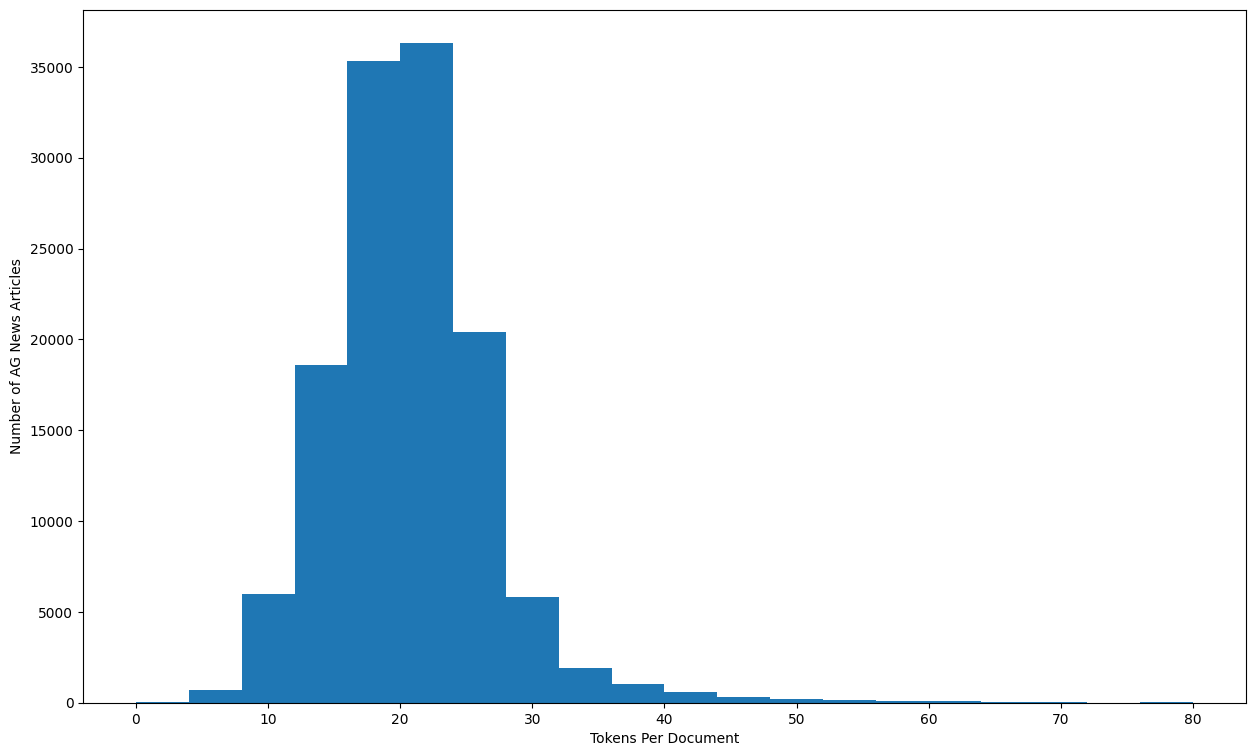

In [7]:
plt.figure(figsize=(15,9))
plt.hist(doc_sizes, bins=20,range = (0,80))
plt.xlabel("Tokens Per Document")
plt.ylabel("Number of AG News Articles");

In [8]:
# Time Stamp
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

# Print the formatted time
print("Last Run:", formatted_time)

Last Run: 2025-07-31 23:25:12


After testing multiple preprocessing configurations, I evaluated three vocabulary sizes (10,000 tokens, 20,000 tokens, and full vocabulary), two standardization methods (custom stopword removal and lower-and-strip-punctuation), and three sequence lengths (64, 128, and 256 tokens). The best results were achieved using the full vocabulary with custom stopword removal and no fixed sequence length. Using the full vocabulary preserved rare but meaningful words that added context, while removing stopwords reduced noise and focused the input on more informative tokens. Allowing variable sequence lengths avoided unnecessary truncation or padding, which maintained the natural flow of text and reduced computational overhead. This combination provided the cleanest and most context-rich input for the models and will be used in subsequent experiments.

In [10]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

Experiment 2- RNN baseline 64 units 

Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.7993 - loss: 0.5202 - val_accuracy: 0.9034 - val_loss: 0.3039
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.9404 - loss: 0.1860 - val_accuracy: 0.8980 - val_loss: 0.3367
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.9720 - loss: 0.0885 - val_accuracy: 0.8918 - val_loss: 0.4142
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9842 - loss: 0.0525 - val_accuracy: 0.8870 - val_loss: 0.5124
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.9886 - loss: 0.0369 - val_accuracy: 0.8811 - val_loss: 0.5529
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9918 - loss: 0.0268 - val_accuracy: 0.8774 - val_loss: 0.6109
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.9928 - loss: 0.0226 - val_accuracy: 0.8796 - val_loss: 0.5979
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9940 -

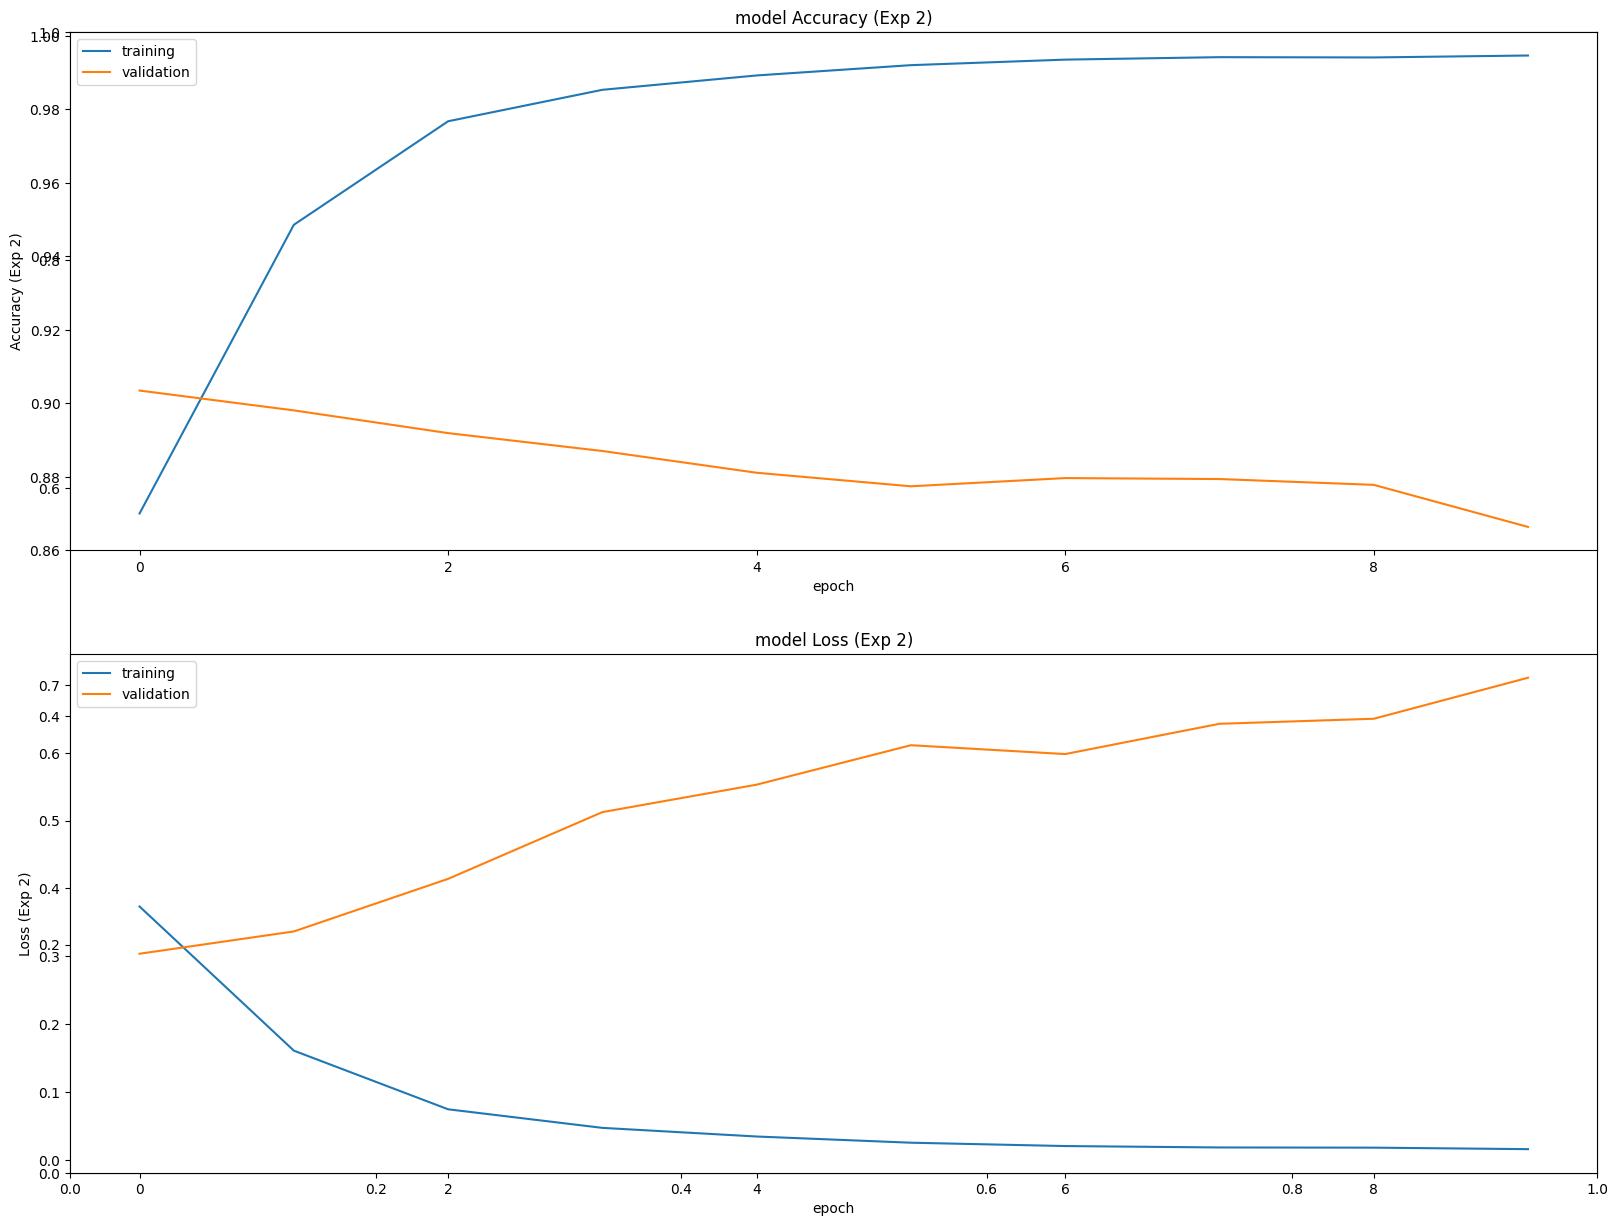

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1900
           1       0.95      0.88      0.92      1900
           2       0.84      0.83      0.83      1900
           3       0.84      0.86      0.85      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600

Accuracy Score: 0.8663157894736843
Root Mean Square Error: 0.6254472084247525


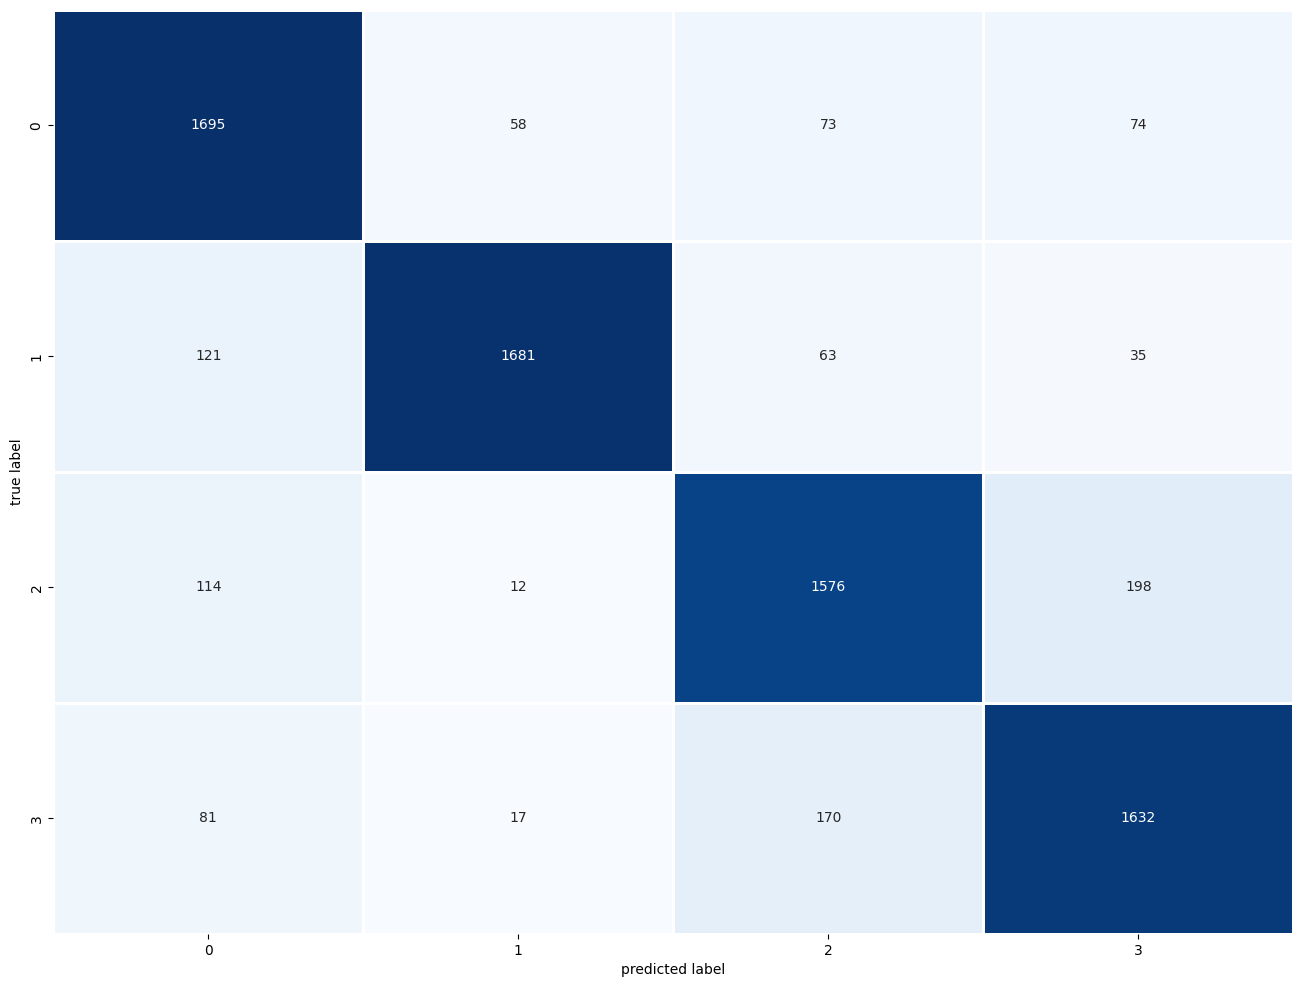

In [11]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import nltk, re, string
from nltk.corpus import stopwords
from collections import Counter

# ======================
# 1. Load Dataset
# ======================
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True, split=ri, as_supervised=True)

train_ds, test_ds = tfds.load('ag_news_subset', split=['train', 'test'], as_supervised=True)
n_classes = info.features['label'].num_classes

# ======================
# 2. Preprocessing Functions
# ======================
nltk.download('stopwords', quiet=True)
STOPWORDS = stopwords.words("english")

def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation), '')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*', "")

# Text Vectorization (from EDA findings)
text_vectorization = layers.TextVectorization(
    max_tokens=None,   # Full vocabulary
    output_mode='int',
    output_sequence_length=128,
    standardize=custom_stopwords  # Using stopword removal
)
text_only_train = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train)

# ======================
# 3. Prepare Dataset for Model
# ======================
batch_size = 100
AUTOTUNE = tf.data.AUTOTUNE

def prepare_dataset(ds):
    return ds.map(lambda x, y: (text_vectorization(x), y)).batch(batch_size).prefetch(AUTOTUNE)

int_train_ds = prepare_dataset(train_ds)
int_test_ds = prepare_dataset(test_ds)

# ======================
# Experiment 2: Baseline RNN (SimpleRNN - 64 units)
# ======================
import time
start_time = time.time()

model2 = tf.keras.Sequential([
    layers.Embedding(input_dim=len(text_vectorization.get_vocabulary()),
                     output_dim=128,
                     mask_zero=True),
    layers.SimpleRNN(64),
    layers.Dense(n_classes, activation='softmax')
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(int_train_ds, validation_data=int_test_ds, epochs=10)

end_time = time.time()
runtime2 = end_time - start_time

# Metrics & Visualization
history_df2 = pd.DataFrame(history2.history)
plt.subplots(figsize=(16, 12))
plt.tight_layout()
display_training_curves(history_df2['accuracy'], history_df2['val_accuracy'], 'Accuracy (Exp 2)', 211)
display_training_curves(history_df2['loss'], history_df2['val_loss'], 'Loss (Exp 2)', 212)
plt.show()

y_test2 = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes2 = np.argmax(model2.predict(int_test_ds), axis=-1)
print_validation_report(y_test2, pred_classes2)
plot_confusion_matrix(y_test2, pred_classes2)

Experiment 3 - RNN - 128 units

Epoch 1/10


2025-08-01 00:03:51.825255: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 20 bytes spill stores, 24 bytes spill loads

2025-08-01 00:03:51.906241: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 40 bytes spill stores, 40 bytes spill loads

2025-08-01 00:03:51.949375: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 36 bytes spill stores, 36 bytes spill loads

2025-08-01 00:03:52.001976: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_32', 60 bytes spill stores, 60 bytes spill loads



1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.8053 - loss: 0.5180 - val_accuracy: 0.8957 - val_loss: 0.3193
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.9386 - loss: 0.1891 - val_accuracy: 0.8809 - val_loss: 0.3721
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9715 - loss: 0.0905 - val_accuracy: 0.8826 - val_loss: 0.4593
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9837 - loss: 0.0532 - val_accuracy: 0.8734 - val_loss: 0.5348
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9882 - loss: 0.0385 - val_accuracy: 0.8703 - val_loss: 0.5992
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9902 - loss: 0.0319 - val_accuracy: 0.8761 - val_loss: 0.6231
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9898 - loss: 0.0317 - val_accuracy: 0.8797 - val_loss: 0.6275
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9916 - loss: 0.02

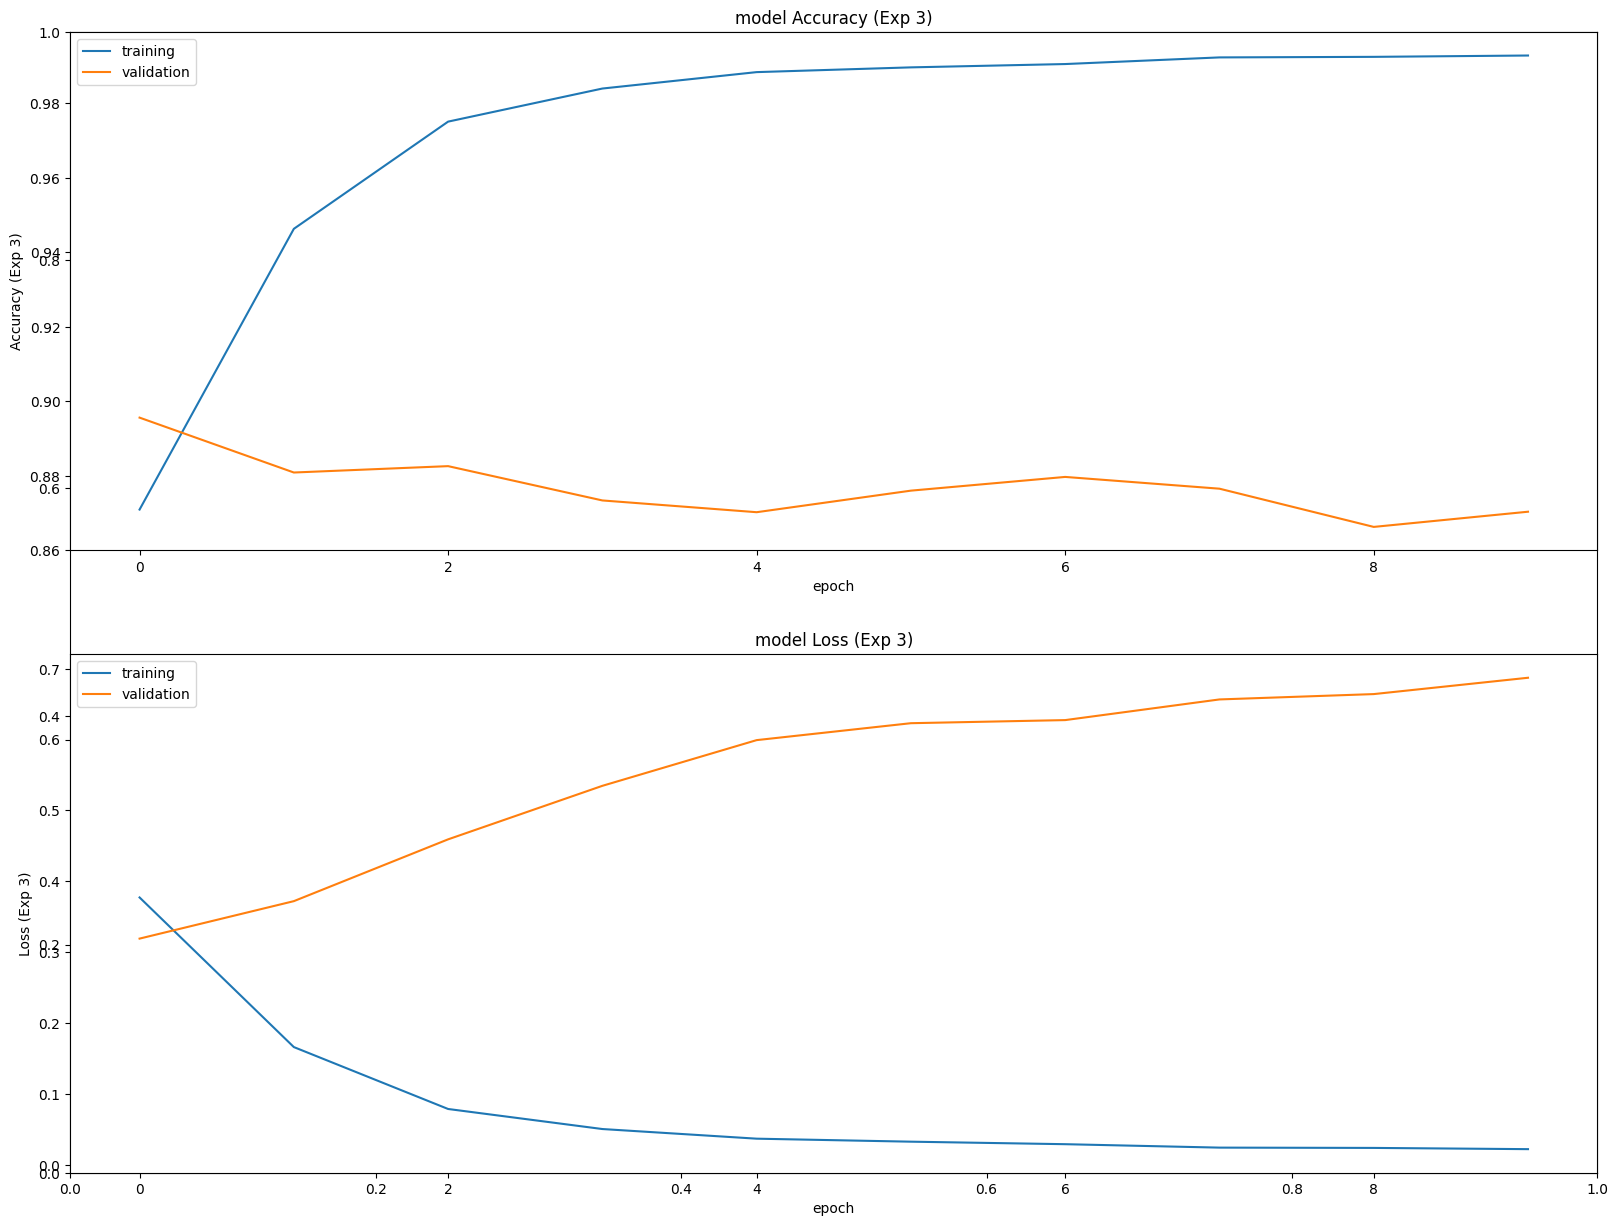

2025-08-01 00:10:22.157558: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1900
           1       0.94      0.95      0.95      1900
           2       0.82      0.82      0.82      1900
           3       0.84      0.85      0.85      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600

Accuracy Score: 0.8703947368421052
Root Mean Square Error: 0.6230231895658798


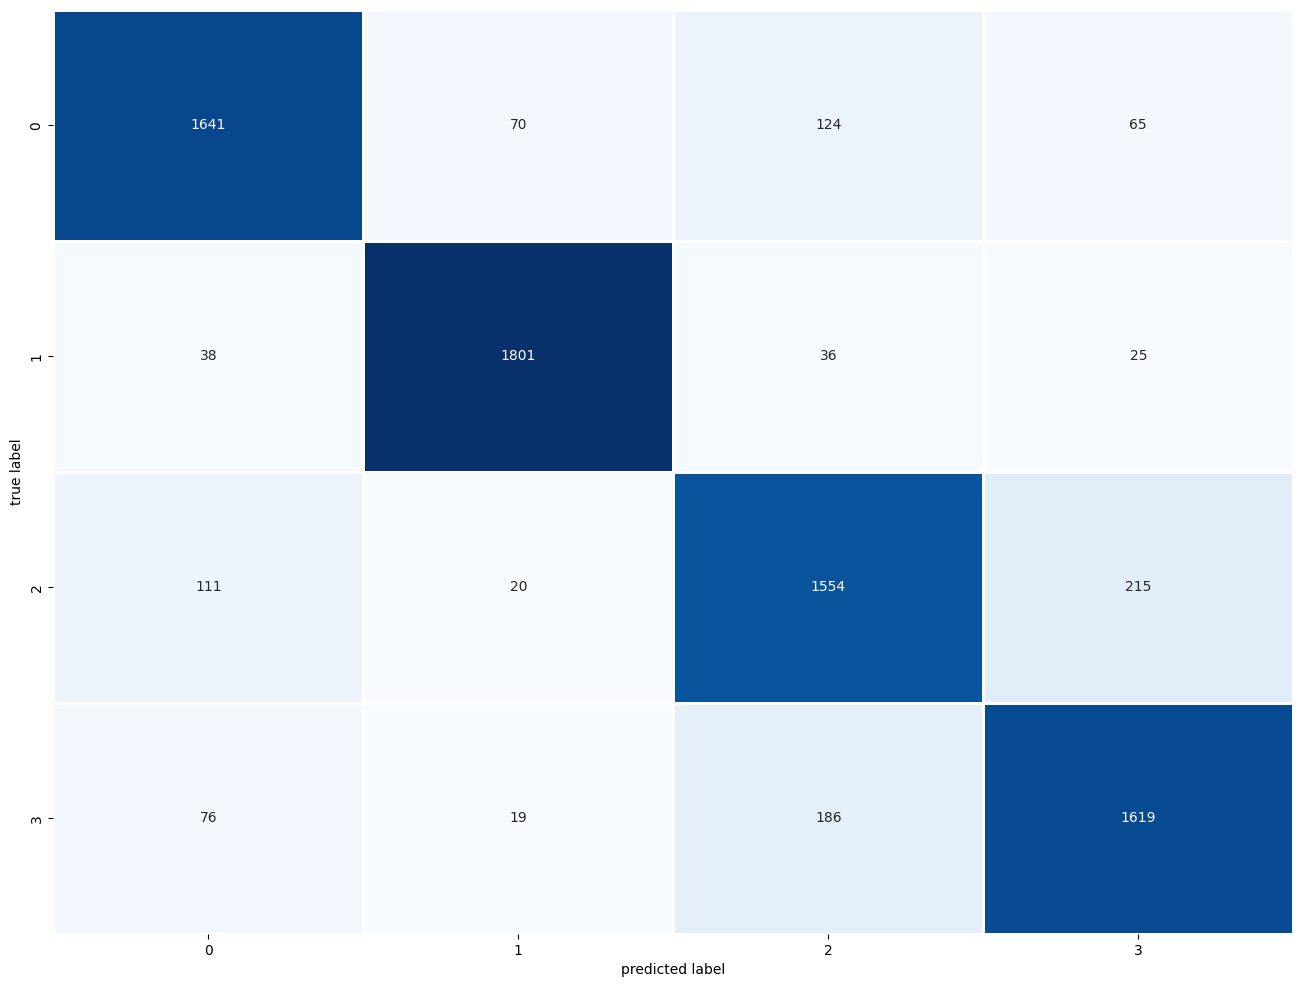

In [12]:
# ======================
# Experiment 3: RNN (128 units)
# ======================
start_time = time.time()

model3 = tf.keras.Sequential([
    layers.Embedding(input_dim=len(text_vectorization.get_vocabulary()),
                     output_dim=128,
                     mask_zero=True),
    layers.SimpleRNN(128),
    layers.Dense(n_classes, activation='softmax')
])

model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history3 = model3.fit(int_train_ds, validation_data=int_test_ds, epochs=10)

end_time = time.time()
runtime3 = end_time - start_time

# Metrics & Visualization
history_df3 = pd.DataFrame(history3.history)
plt.subplots(figsize=(16, 12))
plt.tight_layout()
display_training_curves(history_df3['accuracy'], history_df3['val_accuracy'], 'Accuracy (Exp 3)', 211)
display_training_curves(history_df3['loss'], history_df3['val_loss'], 'Loss (Exp 3)', 212)
plt.show()

y_test3 = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes3 = np.argmax(model3.predict(int_test_ds), axis=-1)
print_validation_report(y_test3, pred_classes3)
plot_confusion_matrix(y_test3, pred_classes3)

Experiment 4 stacked RNN layers 

Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.7997 - loss: 0.5173 - val_accuracy: 0.8964 - val_loss: 0.3177
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9392 - loss: 0.1873 - val_accuracy: 0.8967 - val_loss: 0.3397
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9697 - loss: 0.0941 - val_accuracy: 0.8829 - val_loss: 0.4522
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9782 - loss: 0.0668 - val_accuracy: 0.8816 - val_loss: 0.5188
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9833 - loss: 0.0503 - val_accuracy: 0.8793 - val_loss: 0.5649
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9863 - loss: 0.0399 - val_accuracy: 0.8809 - val_loss: 0.6073
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9875 - loss: 0.0371 - val_accuracy: 0.8766 - val_loss: 0.6172
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9896 -

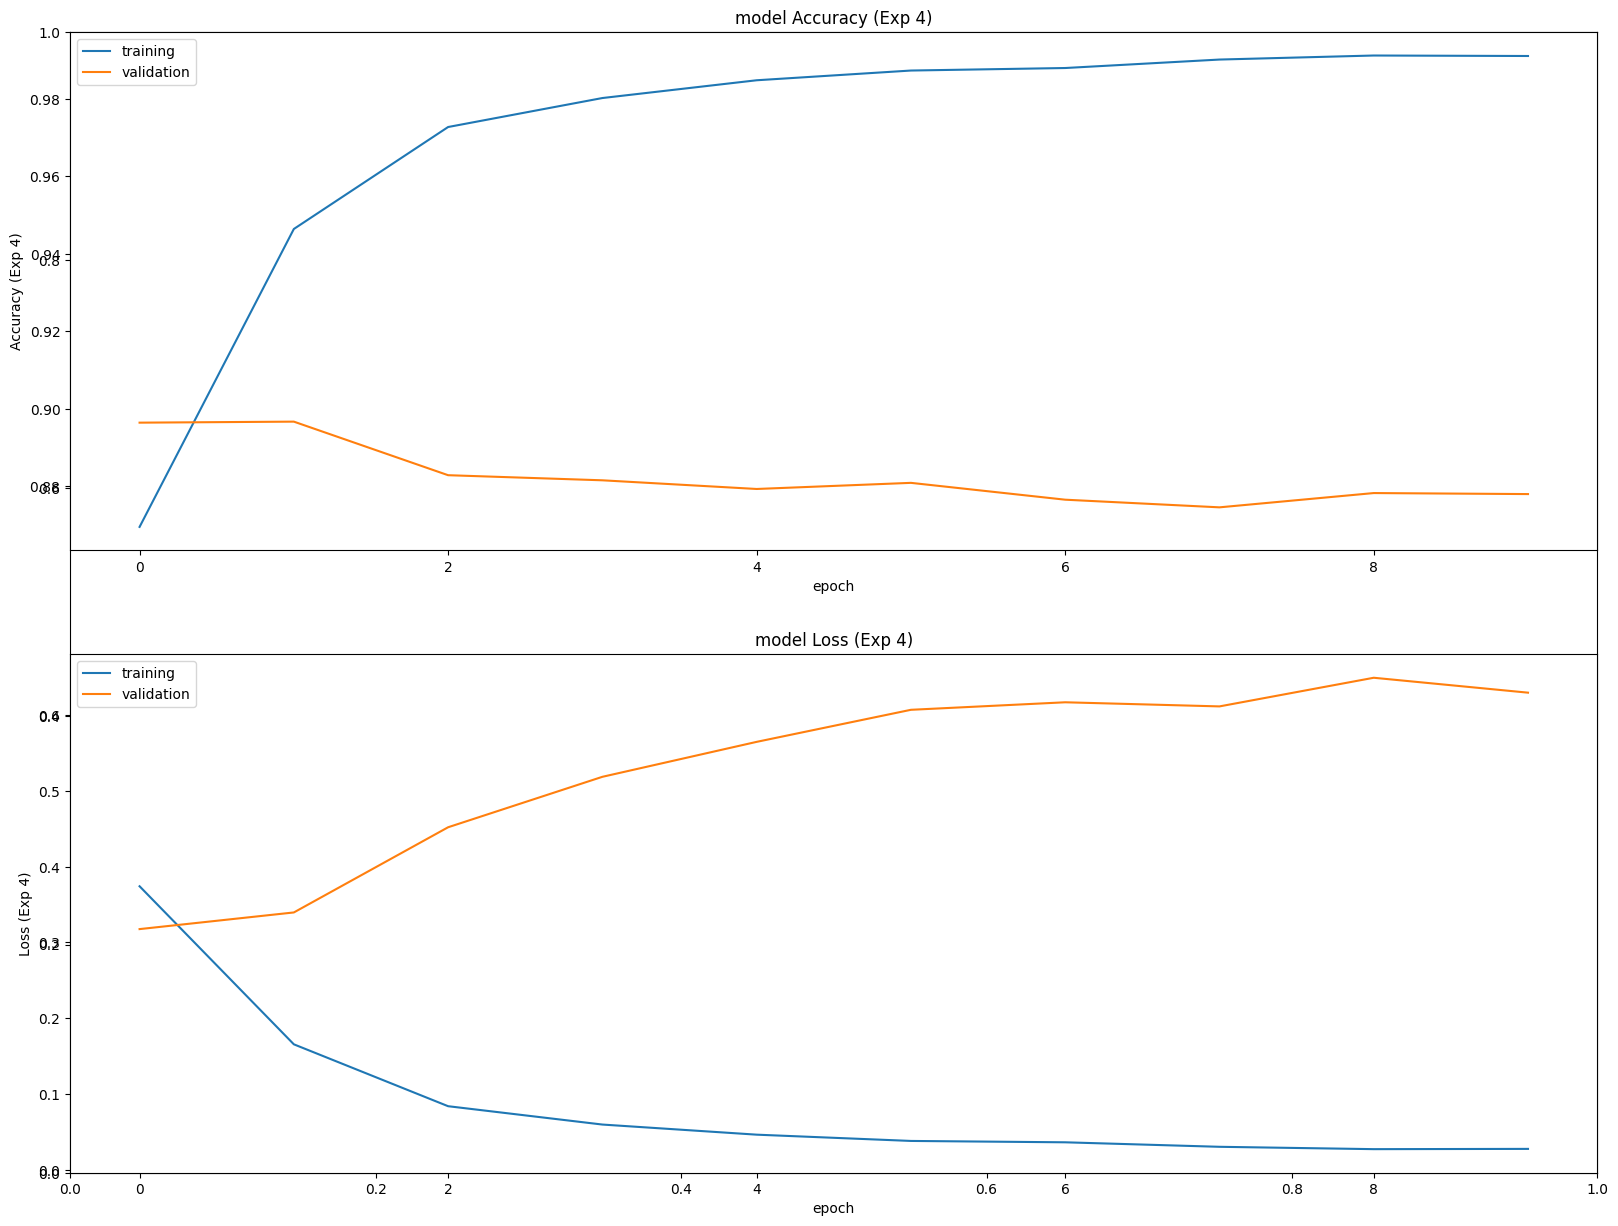

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      1900
           1       0.93      0.94      0.94      1900
           2       0.85      0.83      0.84      1900
           3       0.85      0.84      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

Accuracy Score: 0.8780263157894737
Root Mean Square Error: 0.605022835584697


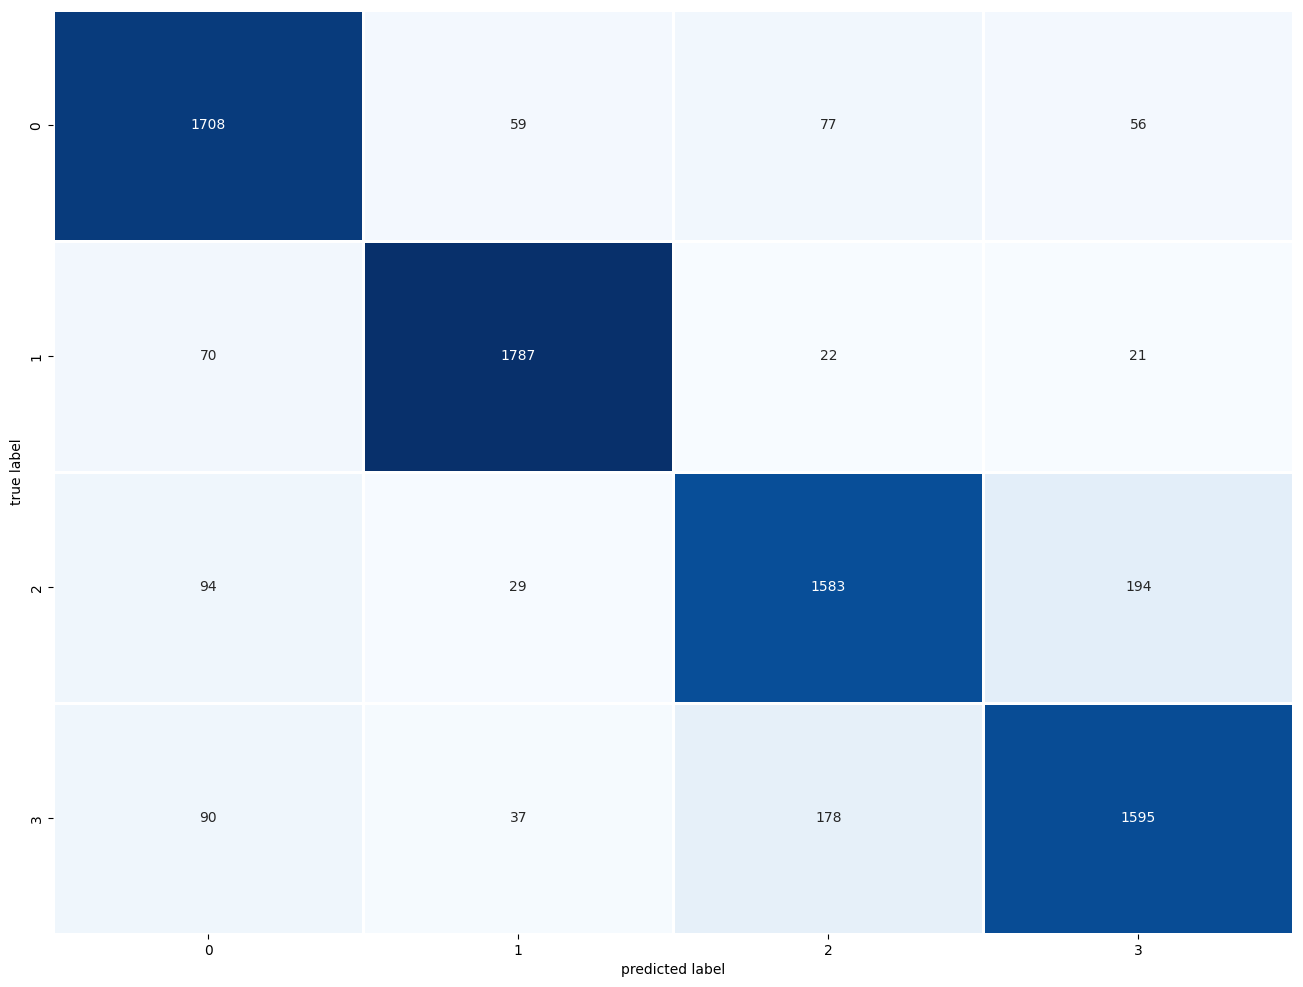

In [13]:
# ======================
# Experiment 4: Stacked RNN (128 → 64 units)
# ======================
start_time = time.time()

model4 = tf.keras.Sequential([
    layers.Embedding(input_dim=len(text_vectorization.get_vocabulary()),
                     output_dim=128,
                     mask_zero=True),
    layers.SimpleRNN(128, return_sequences=True),
    layers.SimpleRNN(64),
    layers.Dense(n_classes, activation='softmax')
])

model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history4 = model4.fit(int_train_ds, validation_data=int_test_ds, epochs=10)

end_time = time.time()
runtime4 = end_time - start_time

# Metrics & Visualization
history_df4 = pd.DataFrame(history4.history)
plt.subplots(figsize=(16, 12))
plt.tight_layout()
display_training_curves(history_df4['accuracy'], history_df4['val_accuracy'], 'Accuracy (Exp 4)', 211)
display_training_curves(history_df4['loss'], history_df4['val_loss'], 'Loss (Exp 4)', 212)
plt.show()

y_test4 = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes4 = np.argmax(model4.predict(int_test_ds), axis=-1)
print_validation_report(y_test4, pred_classes4)
plot_confusion_matrix(y_test4, pred_classes4)

Experiment 5 - RNN Bidirectional 

Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.8133 - loss: 0.4870 - val_accuracy: 0.9082 - val_loss: 0.2747
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.9489 - loss: 0.1528 - val_accuracy: 0.8912 - val_loss: 0.3393
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.9828 - loss: 0.0565 - val_accuracy: 0.8882 - val_loss: 0.4762
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9930 - loss: 0.0248 - val_accuracy: 0.8991 - val_loss: 0.4856
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.9950 - loss: 0.0187 - val_accuracy: 0.8809 - val_loss: 0.5794
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.9959 - loss: 0.0160 - val_accuracy: 0.8825 - val_loss: 0.5955
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.9963 - loss: 0.0145 - val_accuracy: 0.8708 - val_loss: 0.6641
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.9962 -

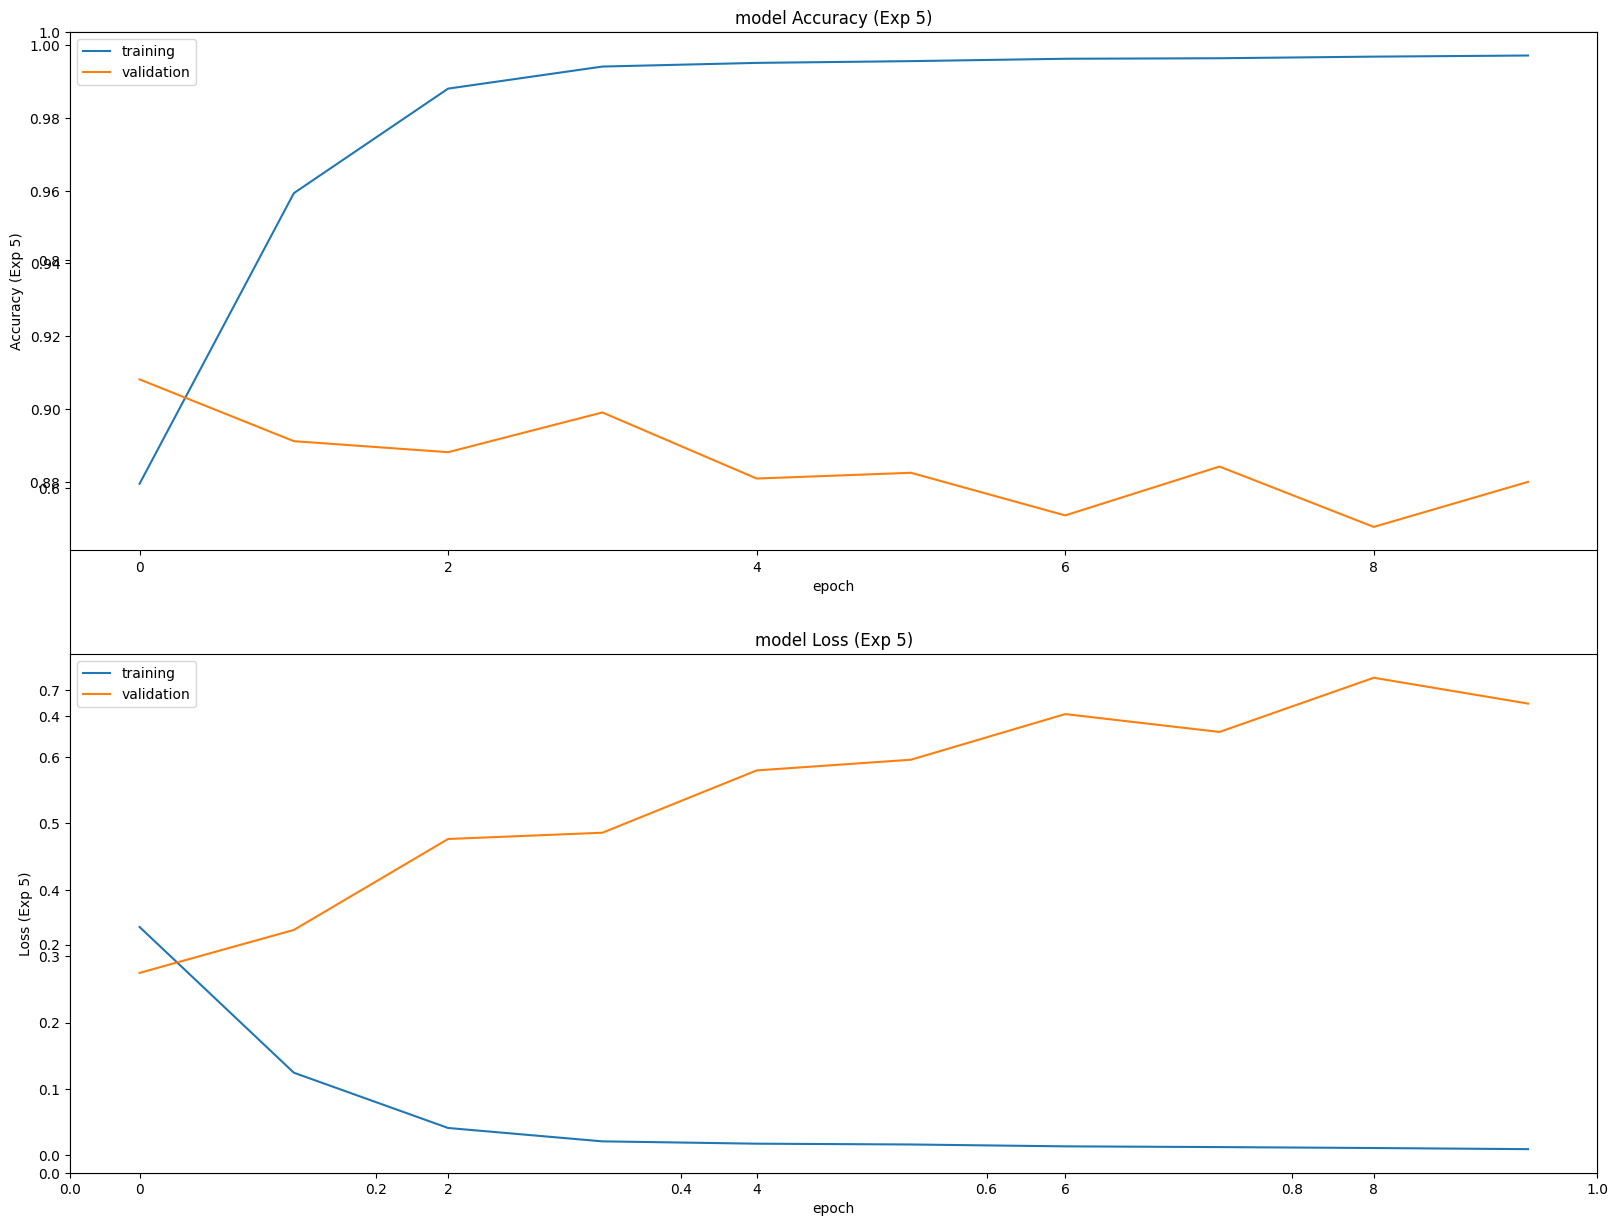

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1900
           1       0.94      0.96      0.95      1900
           2       0.85      0.83      0.84      1900
           3       0.87      0.82      0.84      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

Accuracy Score: 0.88
Root Mean Square Error: 0.6246051384253642


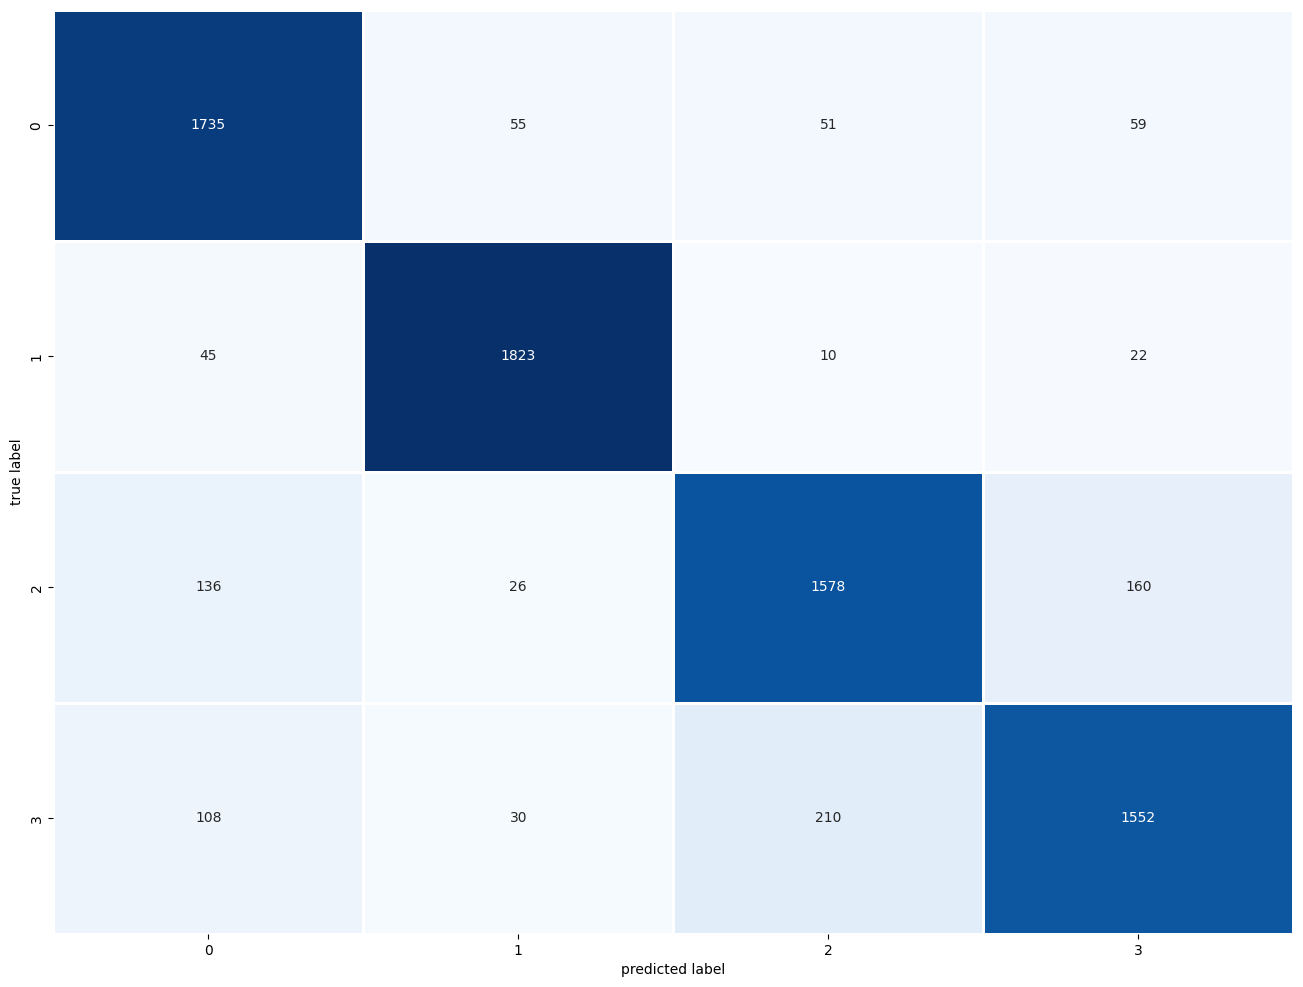

In [14]:
# ======================
# Experiment 5: Bidirectional RNN (64 units)
# ======================
start_time = time.time()

model5 = tf.keras.Sequential([
    layers.Embedding(input_dim=len(text_vectorization.get_vocabulary()),
                     output_dim=128,
                     mask_zero=True),
    layers.Bidirectional(layers.SimpleRNN(64)),
    layers.Dense(n_classes, activation='softmax')
])

model5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history5 = model5.fit(int_train_ds, validation_data=int_test_ds, epochs=10)

end_time = time.time()
runtime5 = end_time - start_time

# Metrics & Visualization
history_df5 = pd.DataFrame(history5.history)
plt.subplots(figsize=(16, 12))
plt.tight_layout()
display_training_curves(history_df5['accuracy'], history_df5['val_accuracy'], 'Accuracy (Exp 5)', 211)
display_training_curves(history_df5['loss'], history_df5['val_loss'], 'Loss (Exp 5)', 212)
plt.show()

y_test5 = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes5 = np.argmax(model5.predict(int_test_ds), axis=-1)
print_validation_report(y_test5, pred_classes5)
plot_confusion_matrix(y_test5, pred_classes5)

Experiement 6 - LSTM Baseline 

Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.8187 - loss: 0.4860 - val_accuracy: 0.9096 - val_loss: 0.2725
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9370 - loss: 0.1909 - val_accuracy: 0.9008 - val_loss: 0.3030
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9587 - loss: 0.1261 - val_accuracy: 0.8986 - val_loss: 0.3387
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9732 - loss: 0.0820 - val_accuracy: 0.8888 - val_loss: 0.4258
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9817 - loss: 0.0547 - val_accuracy: 0.8801 - val_loss: 0.5279
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9860 - loss: 0.0396 - val_accuracy: 0.8868 - val_loss: 0.5850
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9897 - loss: 0.0293 - val_accuracy: 0.8874 - val_loss: 0.6168
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.9922 -

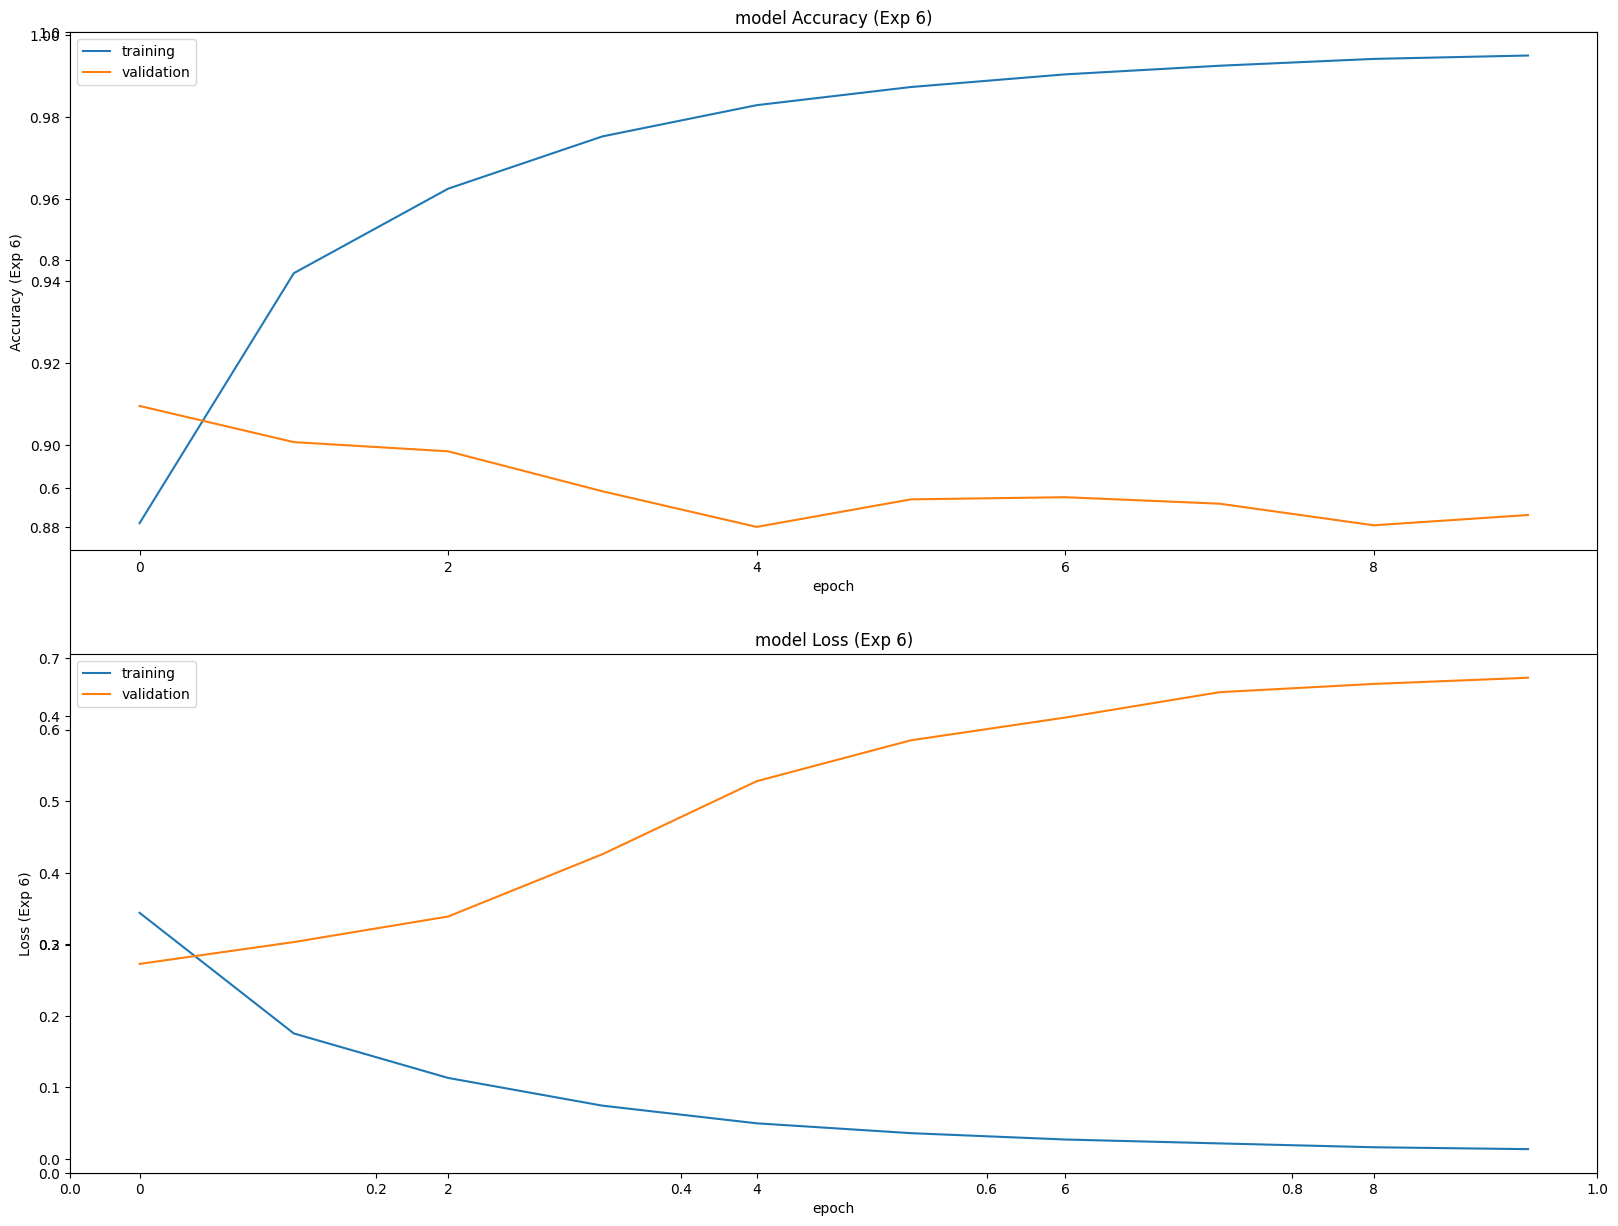

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1900
           1       0.95      0.96      0.95      1900
           2       0.86      0.81      0.83      1900
           3       0.84      0.87      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

Accuracy Score: 0.8830263157894737
Root Mean Square Error: 0.5983530026576901


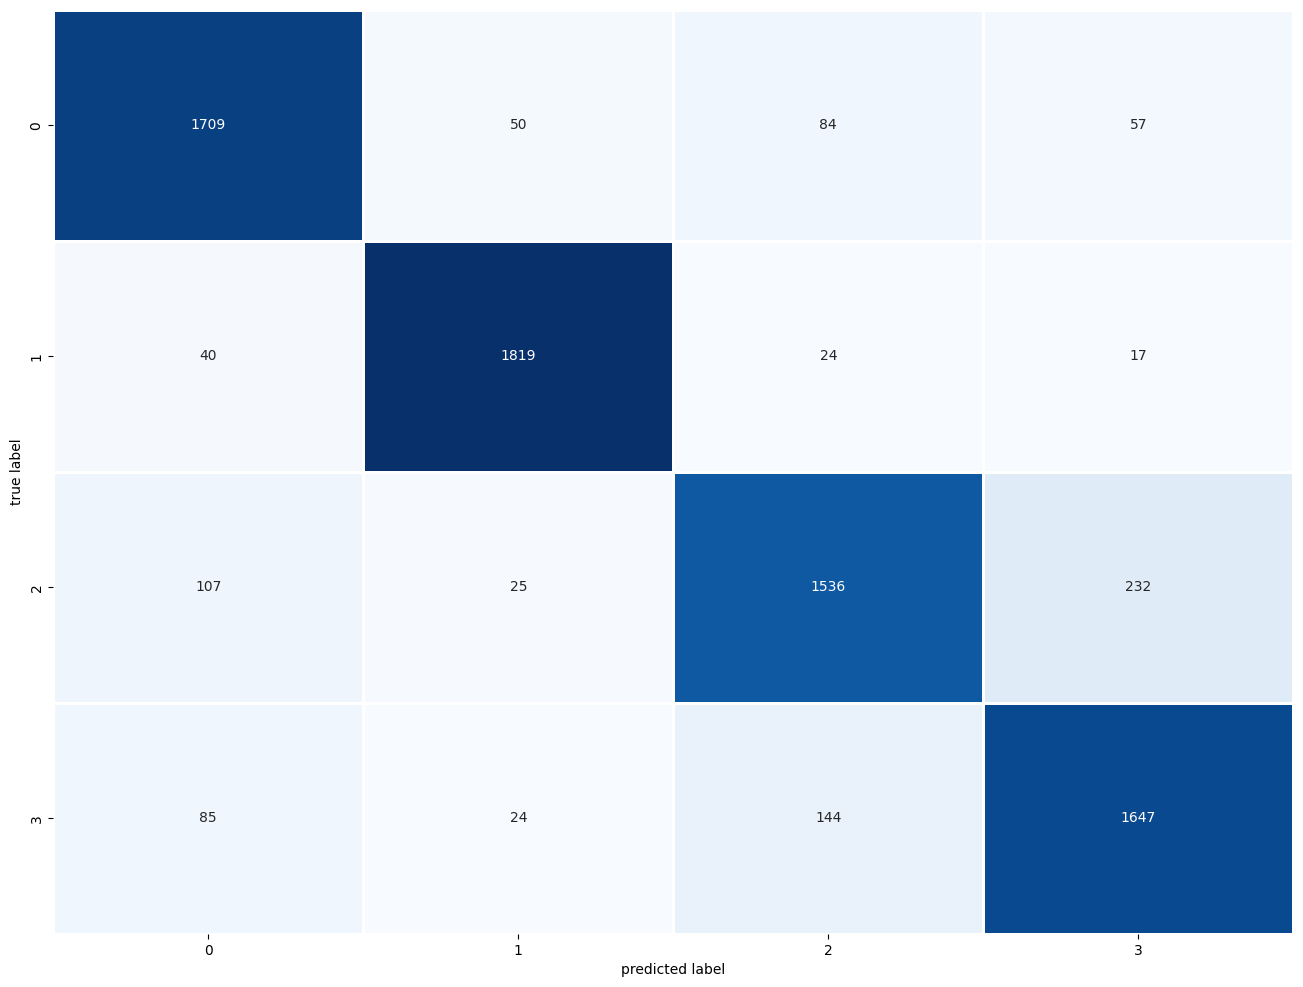

In [15]:
# ======================
# Experiment 6: Baseline LSTM (Single Layer - 128 units)
# ======================
model6 = tf.keras.Sequential([
    layers.Embedding(input_dim=len(text_vectorization.get_vocabulary()),
                     output_dim=128,
                     mask_zero=True),
    layers.LSTM(128),
    layers.Dense(n_classes, activation='softmax')
])

model6.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history6 = model6.fit(int_train_ds, validation_data=int_test_ds, epochs=10)

# Metrics & Visualization
history_df6 = pd.DataFrame(history6.history)
plt.subplots(figsize=(16, 12))
plt.tight_layout()
display_training_curves(history_df6['accuracy'], history_df6['val_accuracy'], 'Accuracy (Exp 6)', 211)
display_training_curves(history_df6['loss'], history_df6['val_loss'], 'Loss (Exp 6)', 212)
plt.show()

y_test6 = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes6 = np.argmax(model6.predict(int_test_ds), axis=-1)
print_validation_report(y_test6, pred_classes6)
plot_confusion_matrix(y_test6, pred_classes6)

Experiment 7 - Stacked LSTM

Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.8191 - loss: 0.4715 - val_accuracy: 0.9083 - val_loss: 0.2765
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.9365 - loss: 0.1930 - val_accuracy: 0.9009 - val_loss: 0.2965
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.9602 - loss: 0.1242 - val_accuracy: 0.8992 - val_loss: 0.3542
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.9757 - loss: 0.0768 - val_accuracy: 0.8876 - val_loss: 0.4272
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9840 - loss: 0.0513 - val_accuracy: 0.8772 - val_loss: 0.5329
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.9873 - loss: 0.0373 - val_accuracy: 0.8824 - val_loss: 0.5766
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.9908 - loss: 0.0291 - val_accuracy: 0.8811 - val_loss: 0.5993
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.9928 -

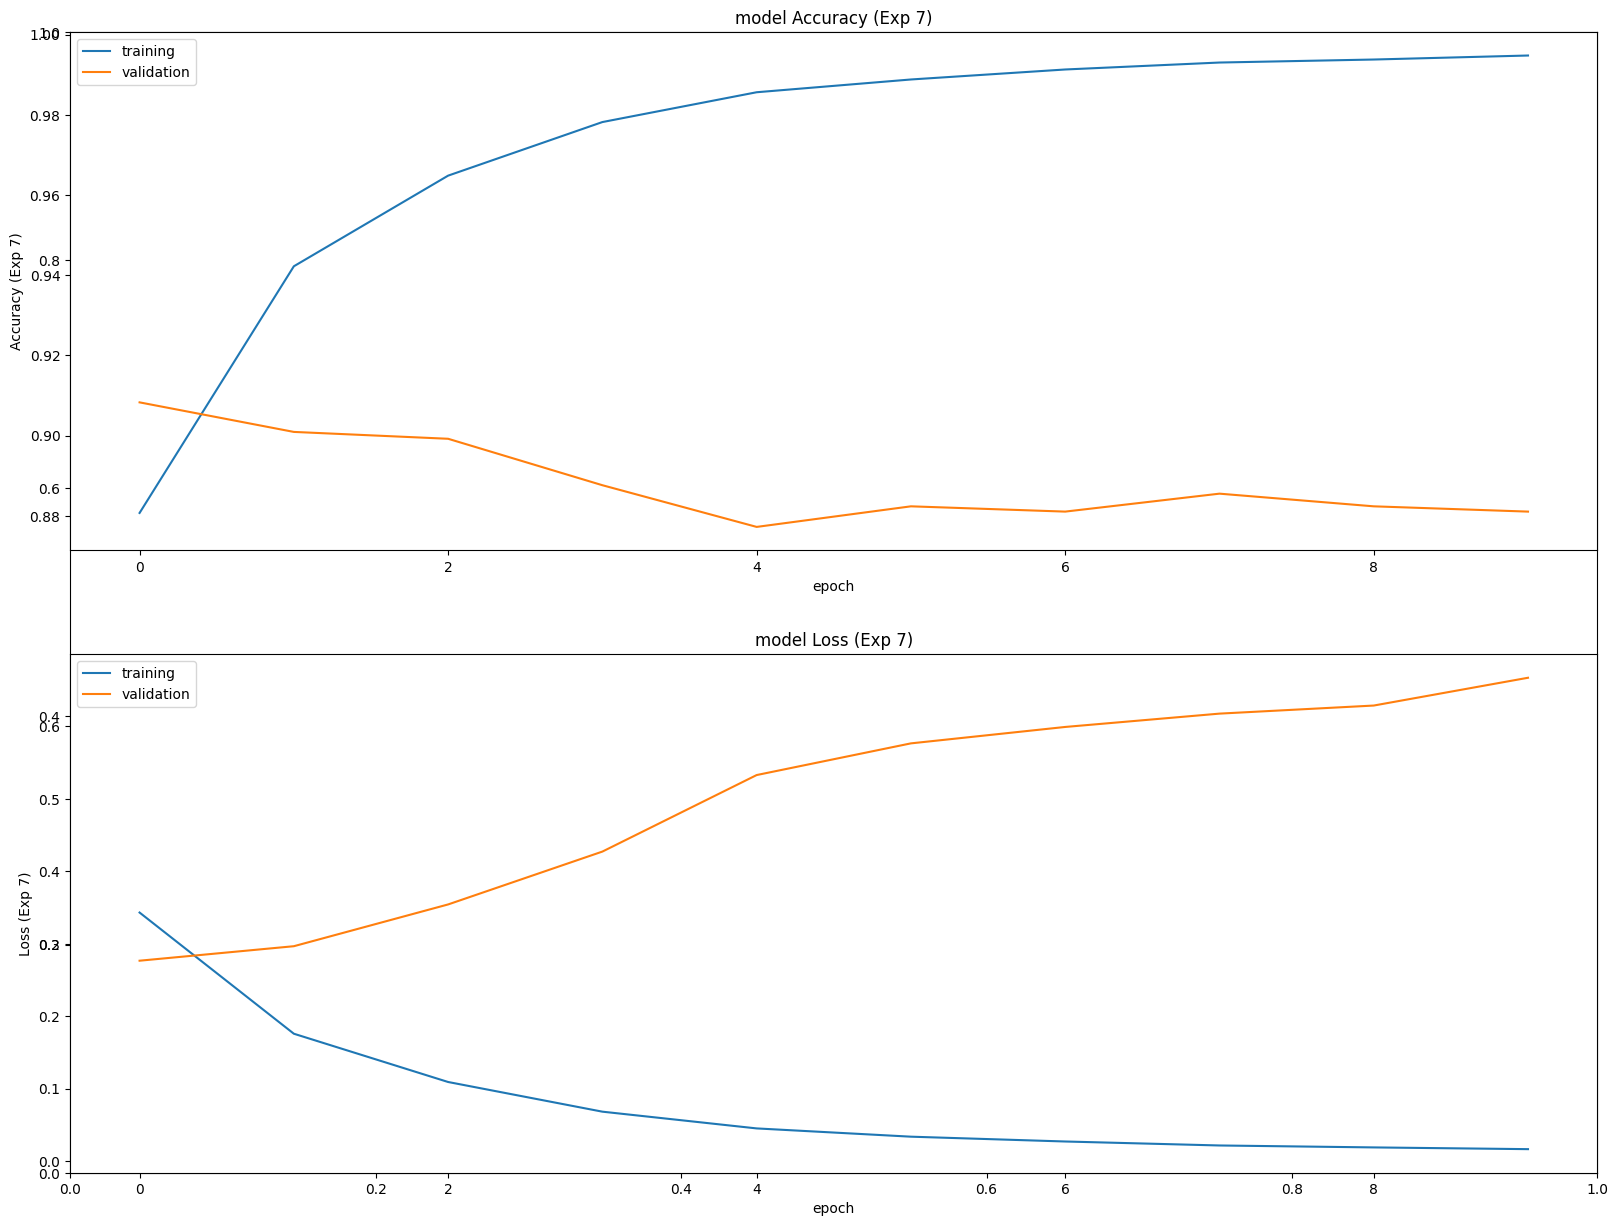

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      1900
           1       0.95      0.96      0.95      1900
           2       0.84      0.83      0.84      1900
           3       0.85      0.83      0.84      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

Accuracy Score: 0.8810526315789474
Root Mean Square Error: 0.6027349945740753


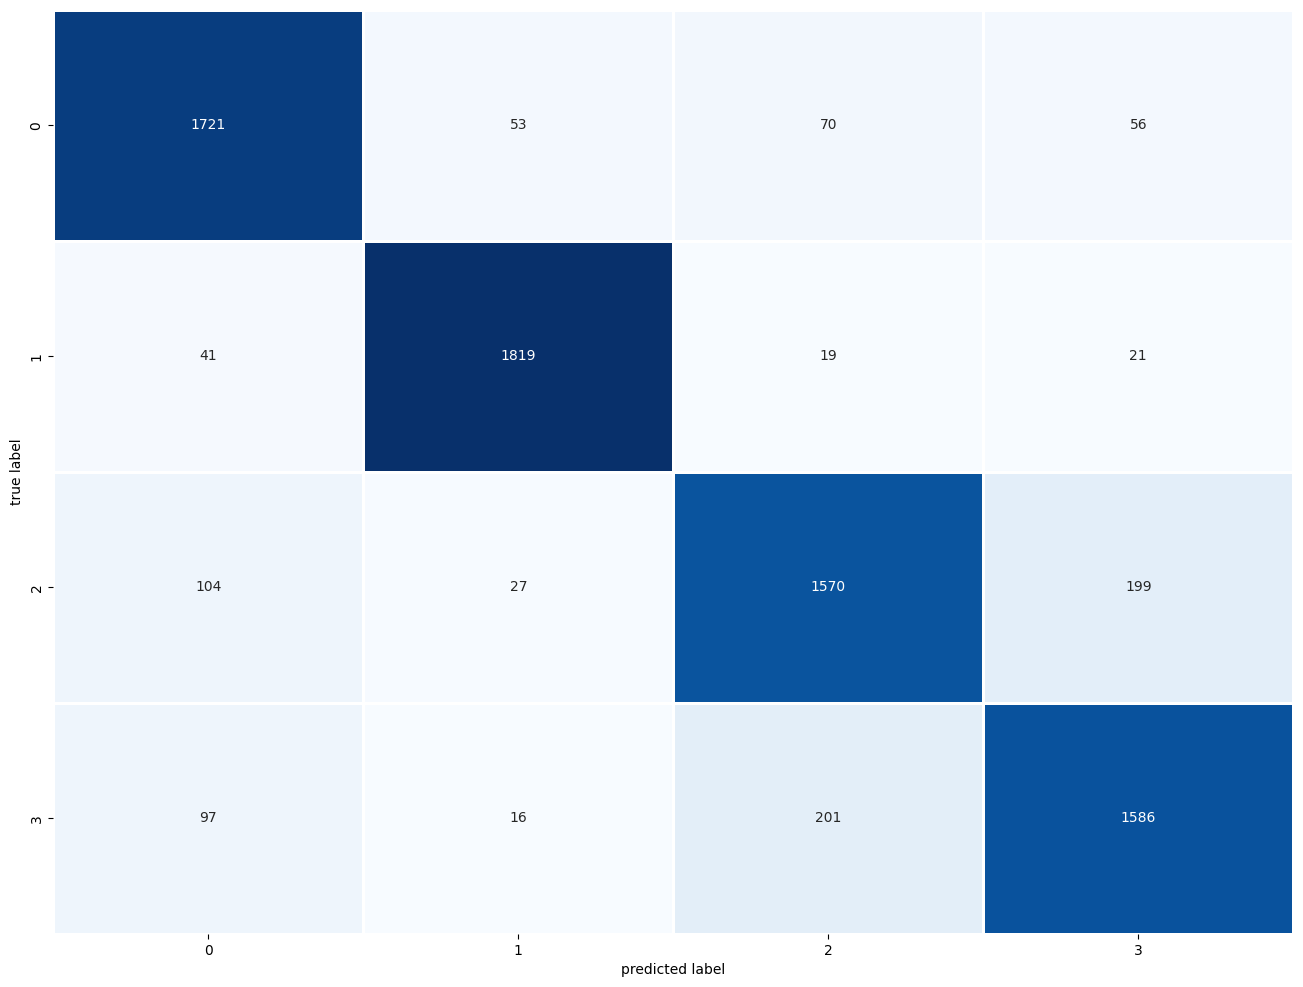

In [16]:
# ======================
# Experiment 7: Stacked LSTM (128 → 64)
# ======================
model7 = tf.keras.Sequential([
    layers.Embedding(input_dim=len(text_vectorization.get_vocabulary()),
                     output_dim=128,
                     mask_zero=True),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(n_classes, activation='softmax')
])

model7.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history7 = model7.fit(int_train_ds, validation_data=int_test_ds, epochs=10)

# Metrics & Visualization
history_df7 = pd.DataFrame(history7.history)
plt.subplots(figsize=(16, 12))
plt.tight_layout()
display_training_curves(history_df7['accuracy'], history_df7['val_accuracy'], 'Accuracy (Exp 7)', 211)
display_training_curves(history_df7['loss'], history_df7['val_loss'], 'Loss (Exp 7)', 212)
plt.show()

y_test7 = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes7 = np.argmax(model7.predict(int_test_ds), axis=-1)
print_validation_report(y_test7, pred_classes7)
plot_confusion_matrix(y_test7, pred_classes7)

Experiment 8 LSTM - bidirectional 

Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.8242 - loss: 0.4648 - val_accuracy: 0.9133 - val_loss: 0.2592
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.9402 - loss: 0.1789 - val_accuracy: 0.9053 - val_loss: 0.2969
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.9623 - loss: 0.1140 - val_accuracy: 0.8984 - val_loss: 0.3568
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.9780 - loss: 0.0676 - val_accuracy: 0.8962 - val_loss: 0.4263
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.9862 - loss: 0.0411 - val_accuracy: 0.8854 - val_loss: 0.4881
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.9901 - loss: 0.0298 - val_accuracy: 0.8814 - val_loss: 0.5557
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.9927 - loss: 0.0218 - val_accuracy: 0.8905 - val_loss: 0.5683
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.9945 -

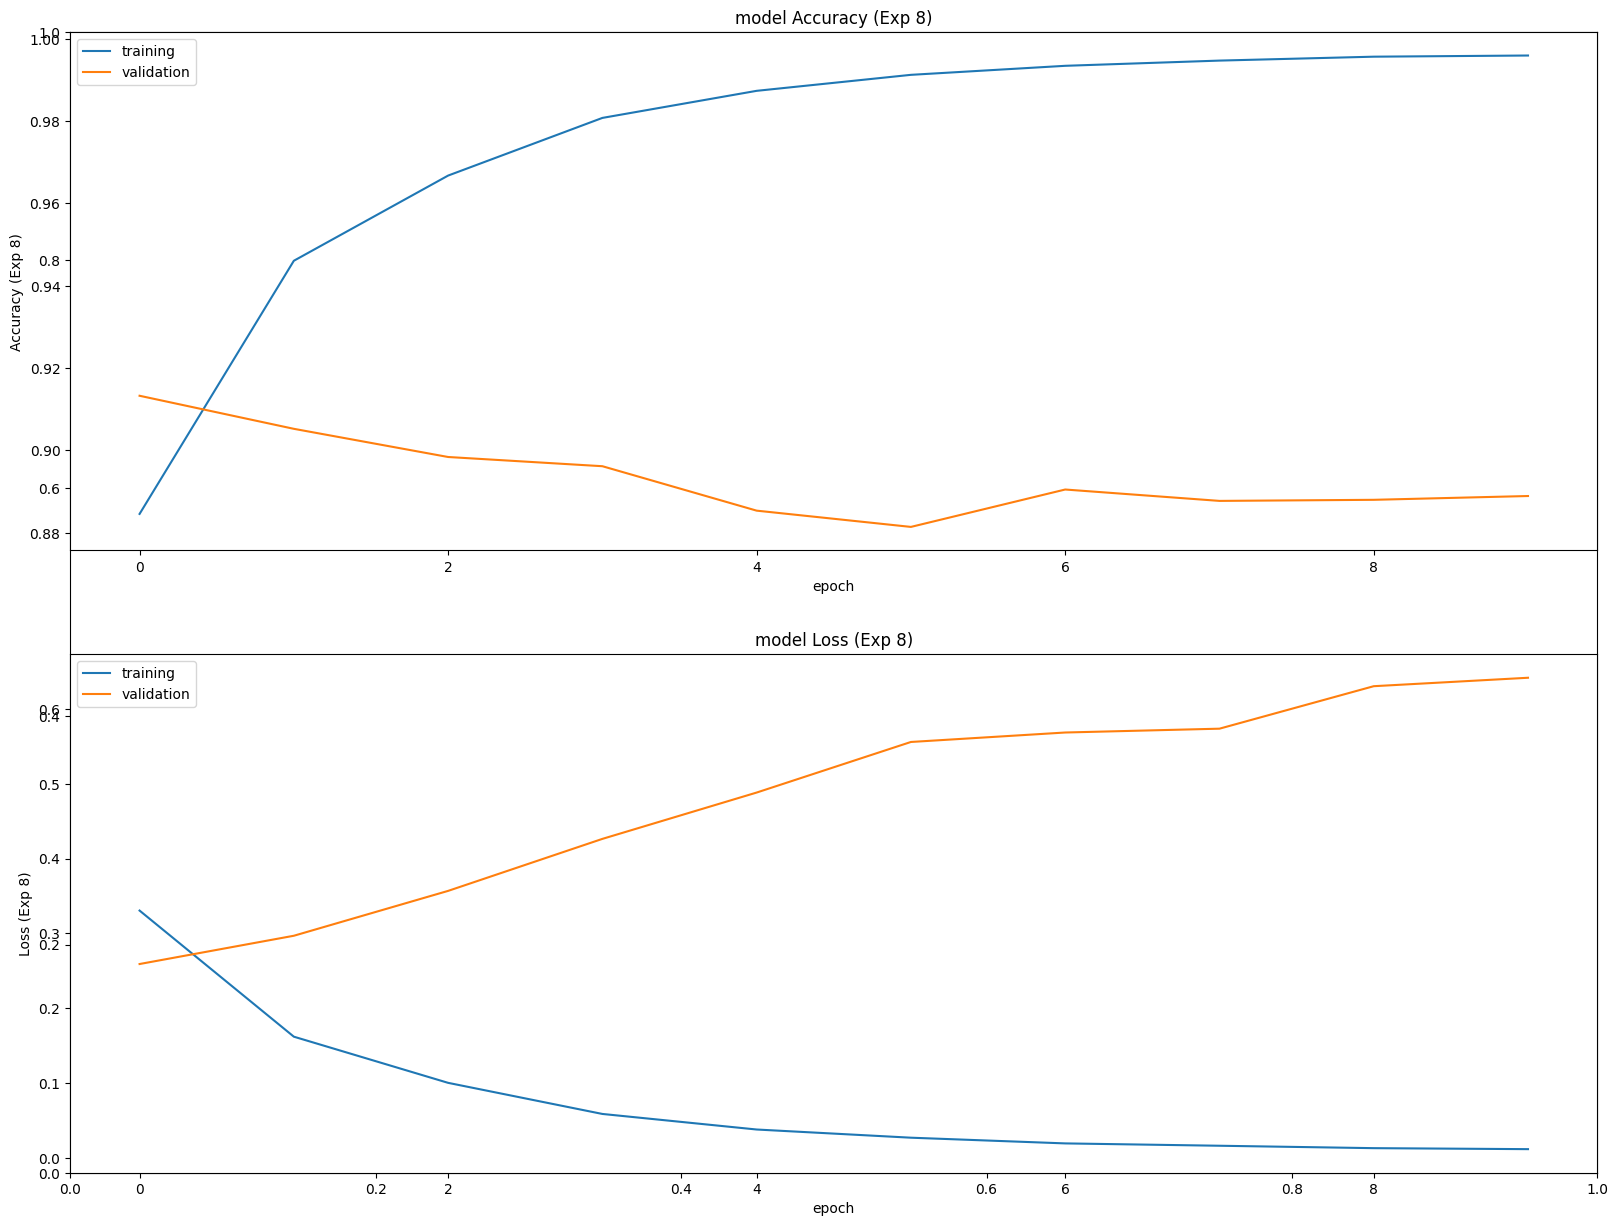

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1900
           1       0.95      0.96      0.96      1900
           2       0.84      0.86      0.85      1900
           3       0.88      0.83      0.85      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600

Accuracy Score: 0.8889473684210526
Root Mean Square Error: 0.5777679373880868


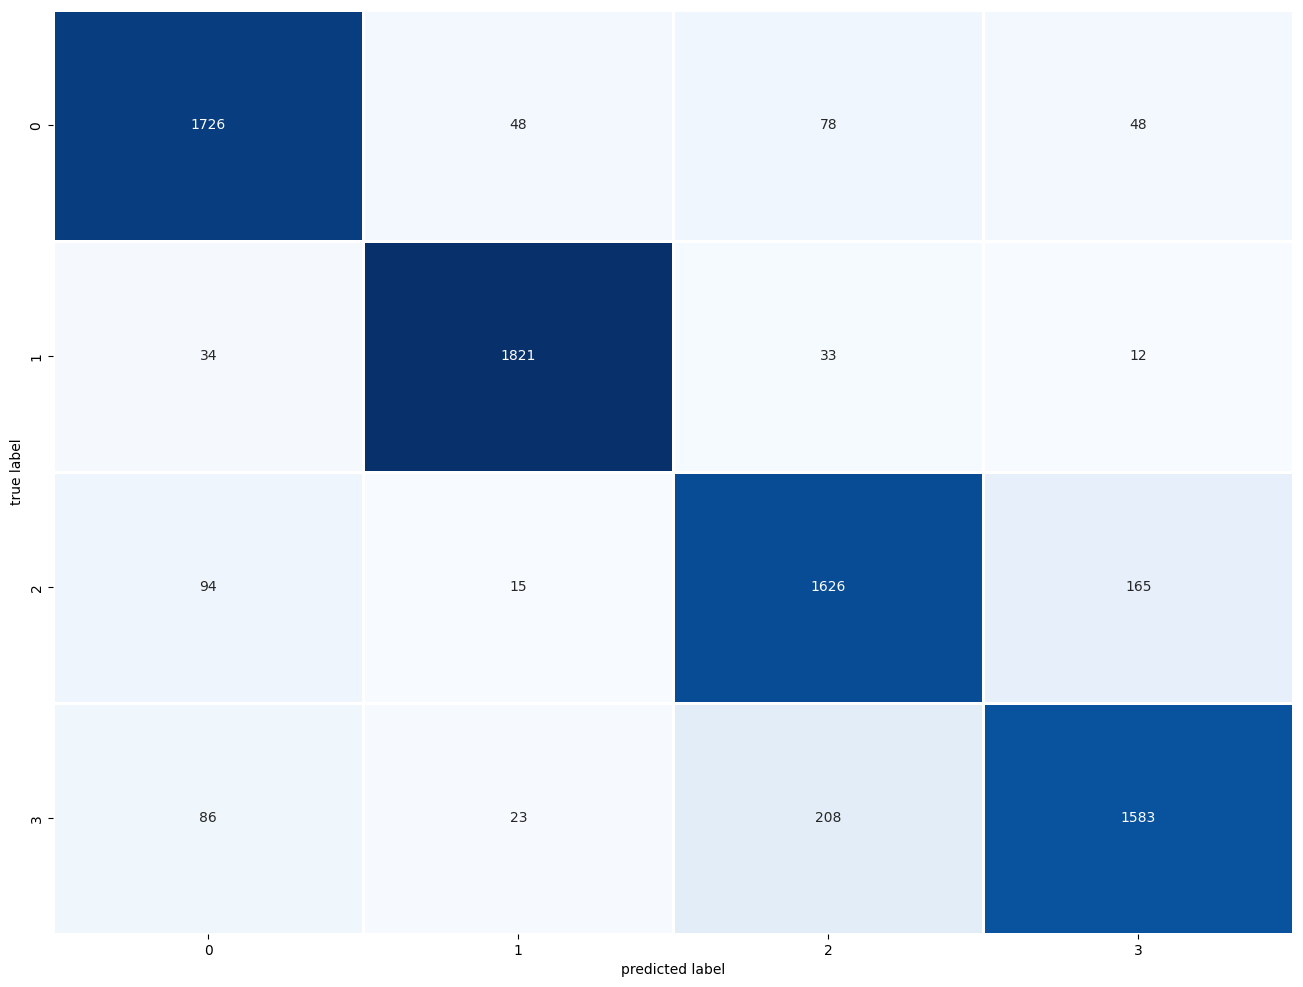

In [17]:
# ======================
# Experiment 8: Bidirectional LSTM (128 units)
# ======================
model8 = tf.keras.Sequential([
    layers.Embedding(input_dim=len(text_vectorization.get_vocabulary()),
                     output_dim=128,
                     mask_zero=True),
    layers.Bidirectional(layers.LSTM(128)),
    layers.Dense(n_classes, activation='softmax')
])

model8.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history8 = model8.fit(int_train_ds, validation_data=int_test_ds, epochs=10)

# Metrics & Visualization
history_df8 = pd.DataFrame(history8.history)
plt.subplots(figsize=(16, 12))
plt.tight_layout()
display_training_curves(history_df8['accuracy'], history_df8['val_accuracy'], 'Accuracy (Exp 8)', 211)
display_training_curves(history_df8['loss'], history_df8['val_loss'], 'Loss (Exp 8)', 212)
plt.show()

y_test8 = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes8 = np.argmax(model8.predict(int_test_ds), axis=-1)
print_validation_report(y_test8, pred_classes8)
plot_confusion_matrix(y_test8, pred_classes8)

Experiment 9 - LSTM -Dropout Regularizatio

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.8218 - loss: 0.4812 - val_accuracy: 0.9068 - val_loss: 0.2814
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.9348 - loss: 0.2019 - val_accuracy: 0.9022 - val_loss: 0.3042
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.9592 - loss: 0.1279 - val_accuracy: 0.8943 - val_loss: 0.3599
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9752 - loss: 0.0802 - val_accuracy: 0.8871 - val_loss: 0.4459
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.9827 - loss: 0.0549 - val_accuracy: 0.8825 - val_loss: 0.5278
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.9875 - loss: 0.0401 - val_accuracy: 0.8858 - val_loss: 0.5958
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.9897 - loss: 0.0316 - val_accuracy: 0.8832 - val_loss: 0.6135
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9913 -

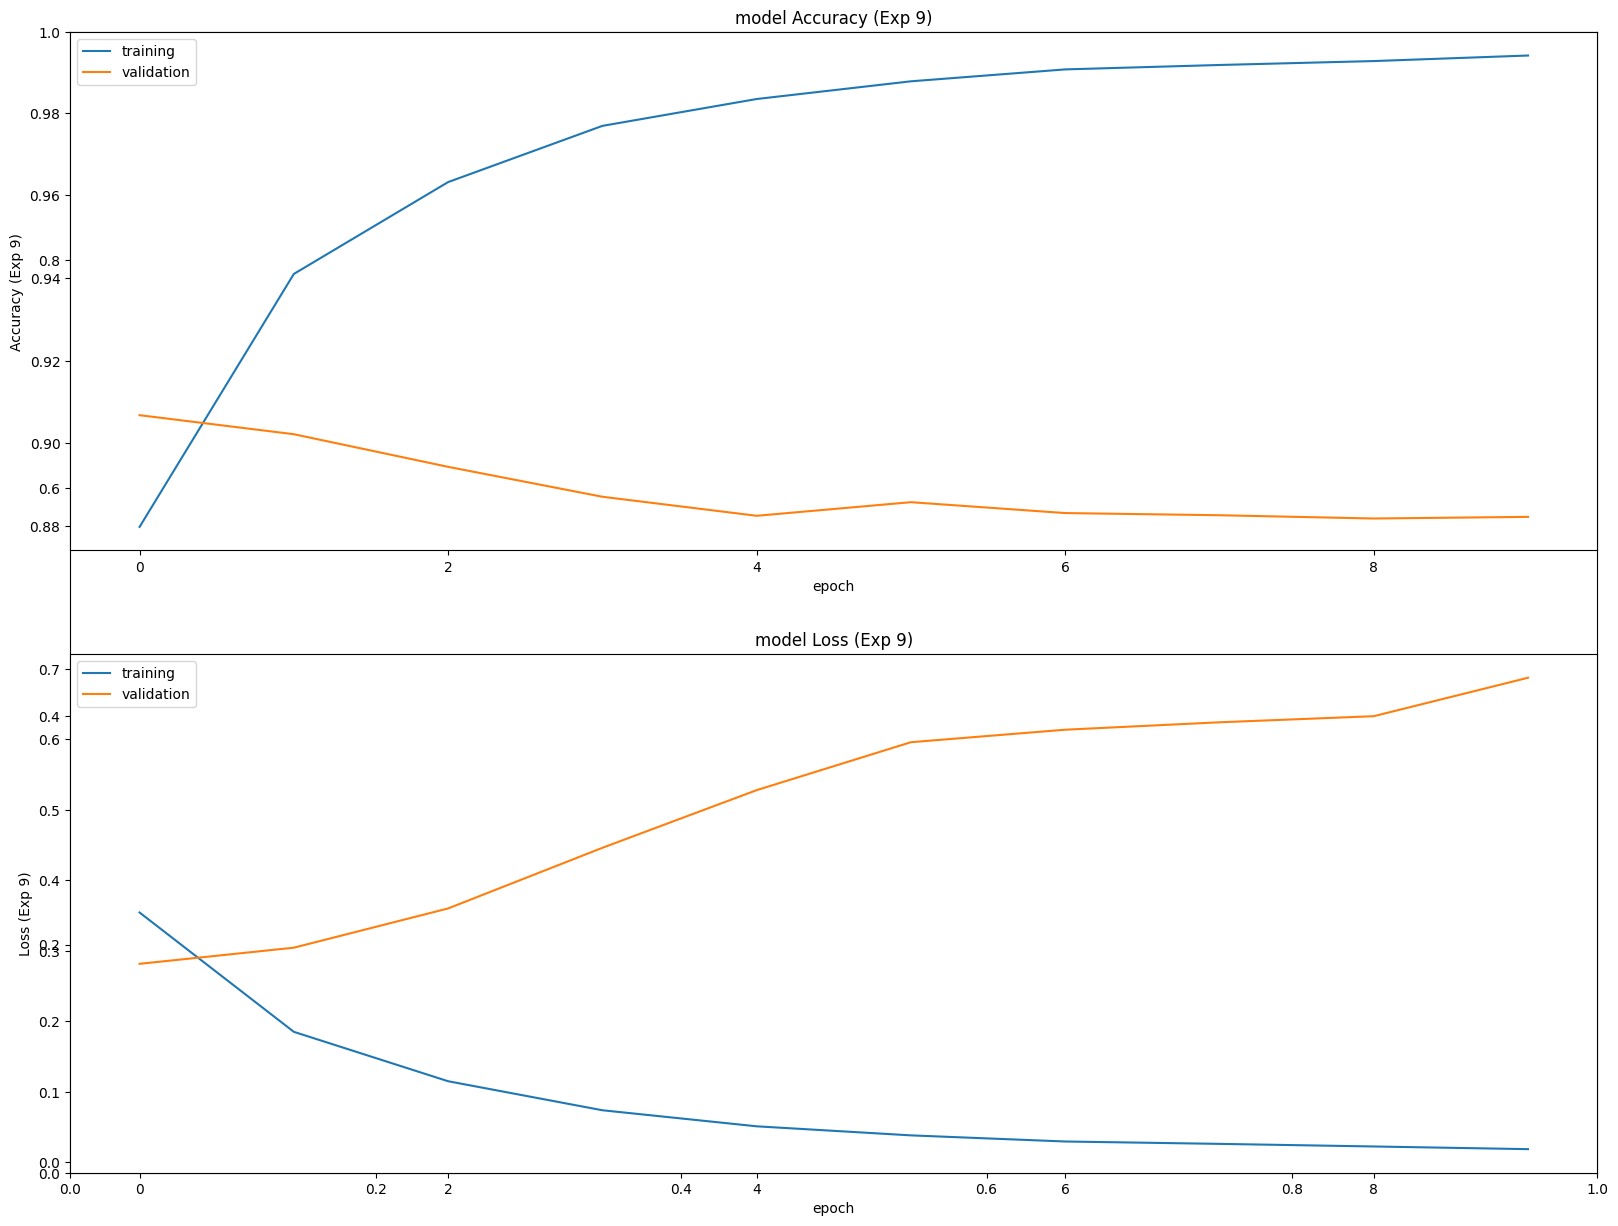

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1900
           1       0.96      0.95      0.95      1900
           2       0.83      0.84      0.84      1900
           3       0.84      0.85      0.84      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

Accuracy Score: 0.8822368421052632
Root Mean Square Error: 0.5937171043518958


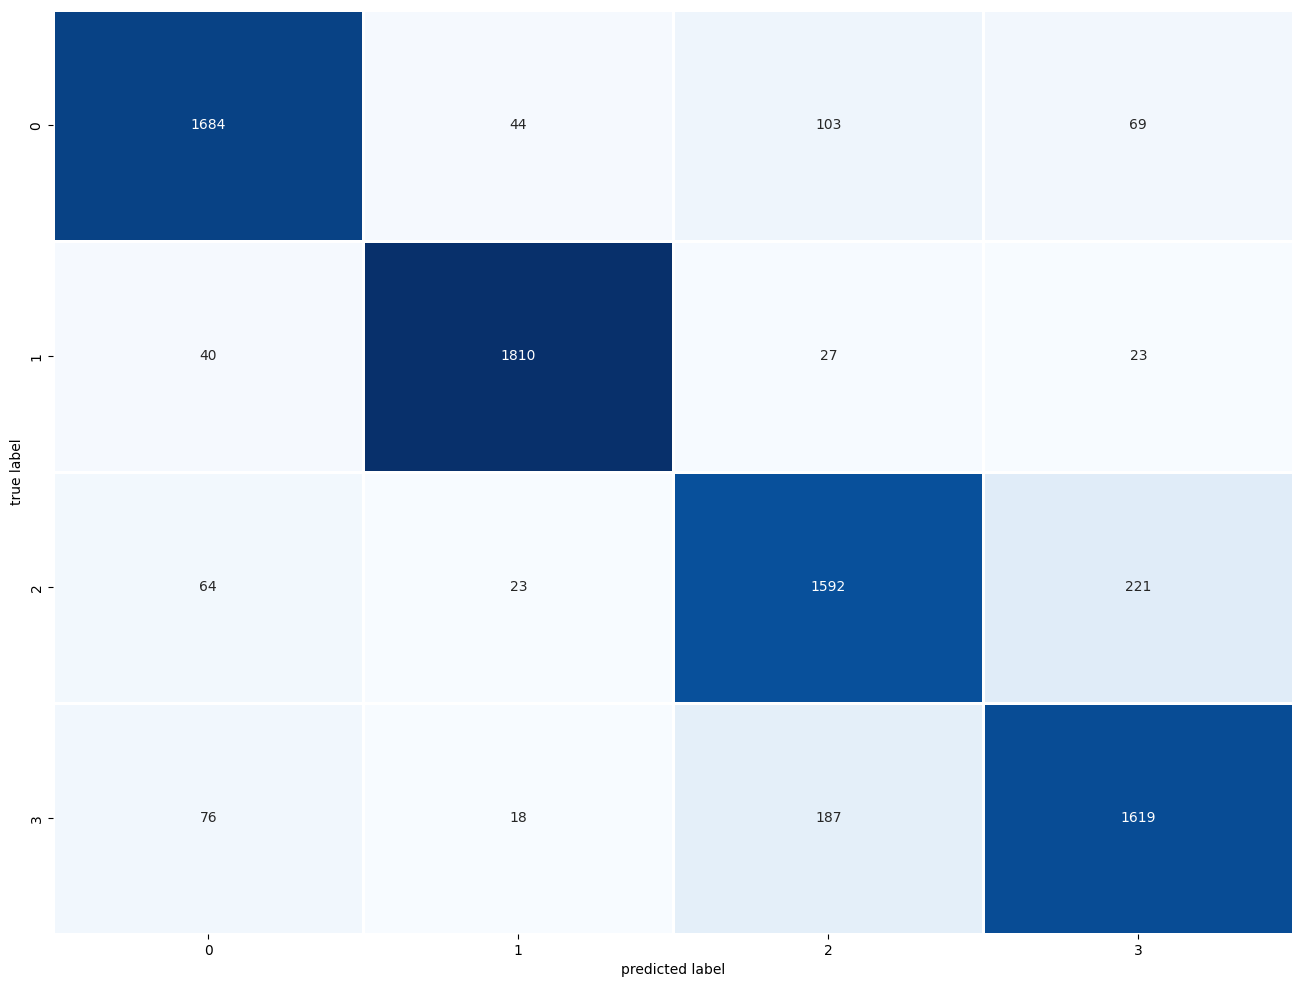

In [27]:
# ======================
# Experiment 9: Stacked LSTM with Dropout Regularization (Sparse Categorical)
# ======================

import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assumptions:
# 1. text_vectorization is already adapted to your training text
# 2. int_train_ds and int_test_ds are preprocessed datasets yielding (features, integer labels)
# 3. n_classes is defined as the number of unique labels

embedding_dim = 128  # Embedding dimension (can be tuned)

# ======================
# 1. Build Model
# ======================
model9 = tf.keras.Sequential([
    layers.Embedding(input_dim=len(text_vectorization.get_vocabulary()),
                     output_dim=embedding_dim,
                     mask_zero=True),   # Trainable embeddings
    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')
])

# ======================
# 2. Compile Model (Using SparseCategoricalCrossentropy for integer labels)
# ======================
model9.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model9.summary()

# ======================
# 3. Train Model
# ======================
history9 = model9.fit(
    int_train_ds,
    validation_data=int_test_ds,
    epochs=10
)

# ======================
# 4. Convert Training History to DataFrame
# ======================
history_df9 = pd.DataFrame(history9.history)

# ======================
# 5. Visualization
# ======================
plt.subplots(figsize=(16, 12))
plt.tight_layout()
display_training_curves(history_df9['accuracy'], history_df9['val_accuracy'], 'Accuracy (Exp 9)', 211)
display_training_curves(history_df9['loss'], history_df9['val_loss'], 'Loss (Exp 9)', 212)
plt.show()

# ======================
# 6. Evaluation: Predictions & Metrics
# ======================
y_test9 = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes9 = np.argmax(model9.predict(int_test_ds), axis=-1)

print_validation_report(y_test9, pred_classes9)
plot_confusion_matrix(y_test9, pred_classes9)

Experiment 10 - 1D CNN

Epoch 1/10


/home/jameslinux/anaconda3/envs/tf_3.10/lib/python3.10/site-packages/keras/src/layers/layer.py:939: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.8047 - loss: 0.5311 - val_accuracy: 0.9117 - val_loss: 0.2627
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.9439 - loss: 0.1674 - val_accuracy: 0.9072 - val_loss: 0.3016
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.9776 - loss: 0.0711 - val_accuracy: 0.9043 - val_loss: 0.3676
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.9910 - loss: 0.0333 - val_accuracy: 0.8932 - val_loss: 0.4685
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.9937 - loss: 0.0209 - val_accuracy: 0.8993 - val_loss: 0.4972
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.9950 - loss: 0.0153 - val_accuracy: 0.8983 - val_loss: 0.5770
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.9953 - loss: 0.0130 - val_accuracy: 0.8733 - val_loss: 0.7353
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 37s 31ms/step - accuracy: 0.9950 - loss: 0.01

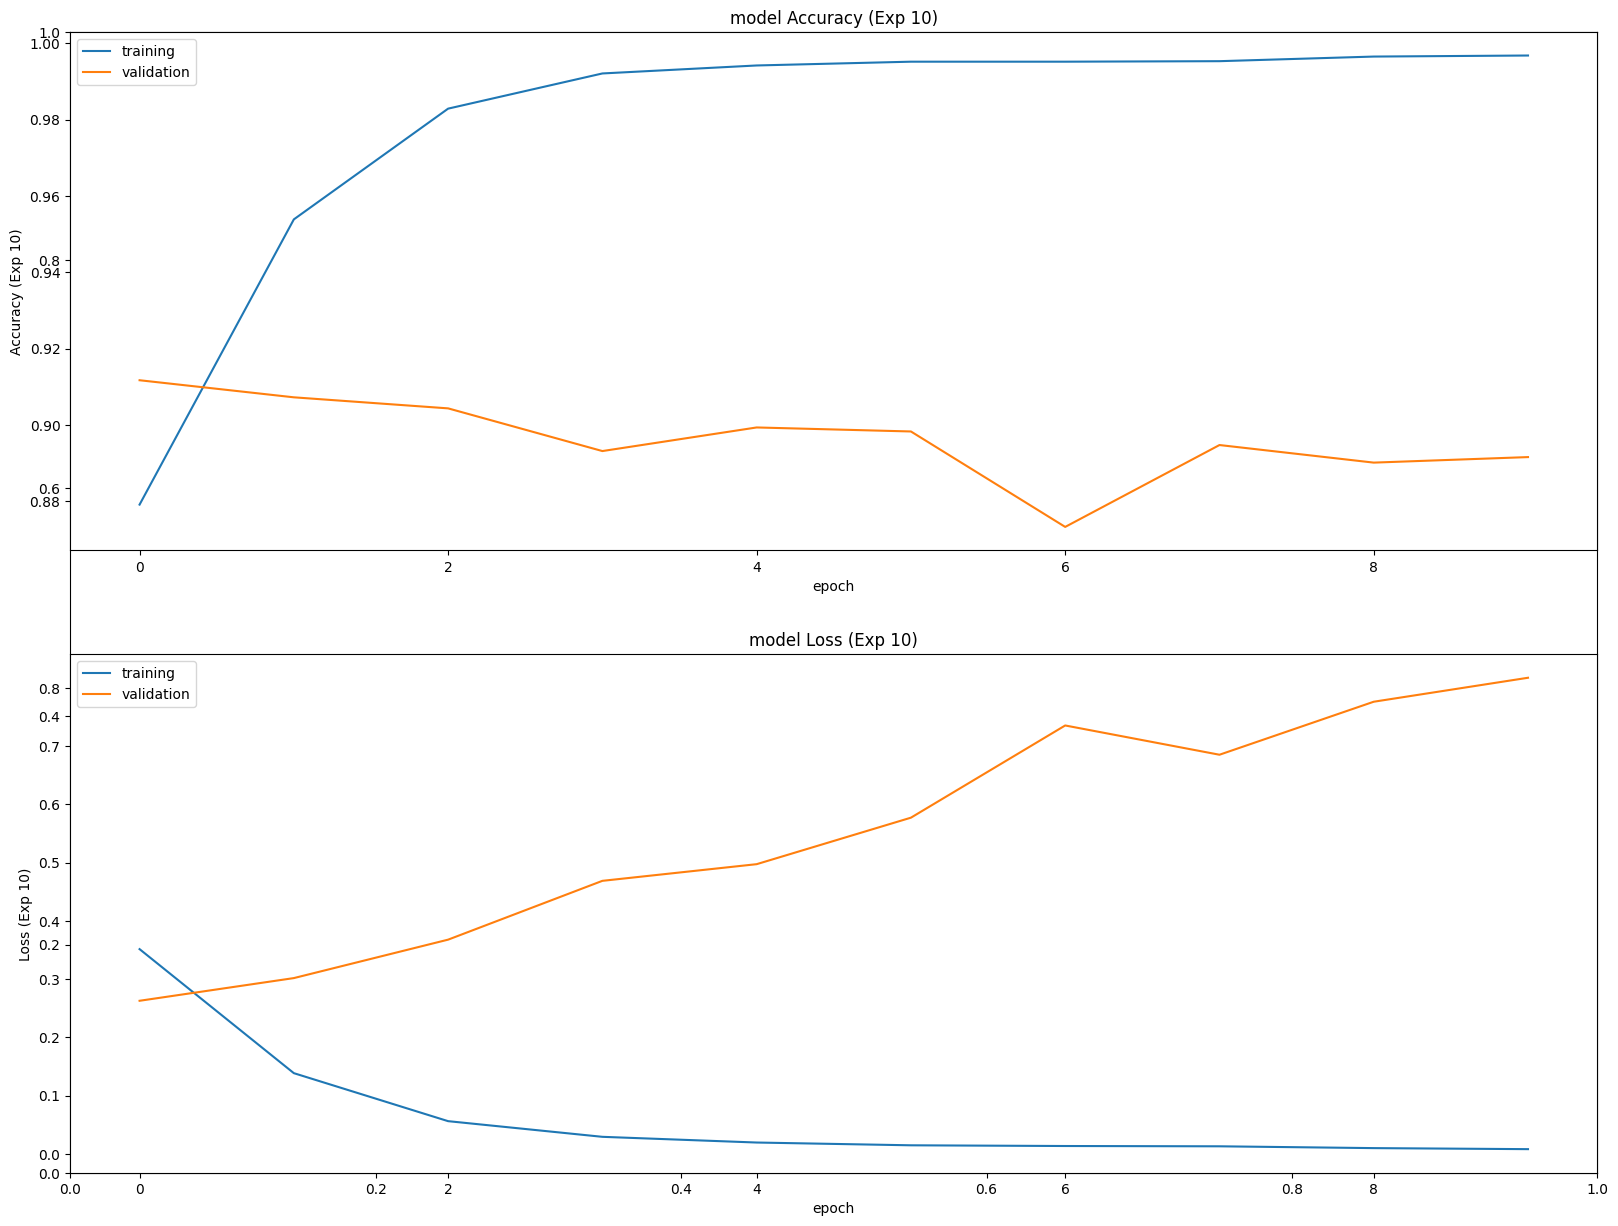

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      1900
           1       0.94      0.96      0.95      1900
           2       0.88      0.82      0.85      1900
           3       0.87      0.87      0.87      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600

Accuracy Score: 0.891578947368421
Root Mean Square Error: 0.5763998977318292


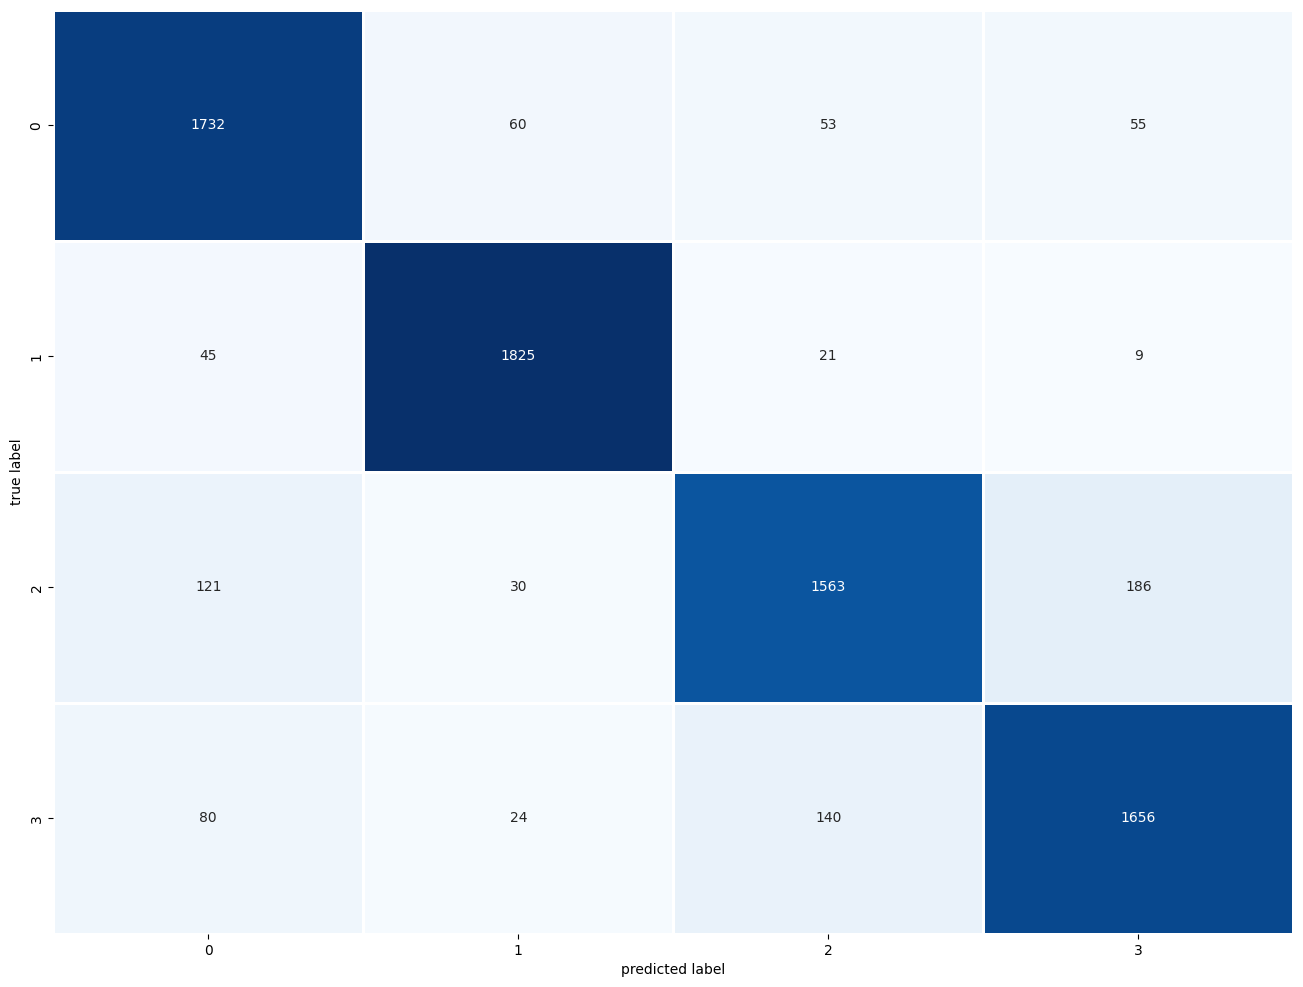

In [28]:
# ======================
# Experiment 10: 1D CNN
# ======================
model10 = tf.keras.Sequential([
    layers.Embedding(input_dim=len(text_vectorization.get_vocabulary()),
                     output_dim=128,
                     mask_zero=True),
    layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model10.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history10 = model10.fit(int_train_ds, validation_data=int_test_ds, epochs=10)

# Metrics & Visualization
history_df10 = pd.DataFrame(history10.history)
plt.subplots(figsize=(16, 12))
plt.tight_layout()
display_training_curves(history_df10['accuracy'], history_df10['val_accuracy'], 'Accuracy (Exp 10)', 211)
display_training_curves(history_df10['loss'], history_df10['val_loss'], 'Loss (Exp 10)', 212)
plt.show()

y_test10 = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes10 = np.argmax(model10.predict(int_test_ds), axis=-1)
print_validation_report(y_test10, pred_classes10)
plot_confusion_matrix(y_test10, pred_classes10)

Experiment 11 -GRU Baseline

Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.8037 - loss: 0.5070 - val_accuracy: 0.9080 - val_loss: 0.2722
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9362 - loss: 0.1881 - val_accuracy: 0.9025 - val_loss: 0.2980
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9604 - loss: 0.1200 - val_accuracy: 0.8941 - val_loss: 0.3692
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9746 - loss: 0.0767 - val_accuracy: 0.8849 - val_loss: 0.4610
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.9829 - loss: 0.0516 - val_accuracy: 0.8708 - val_loss: 0.5905
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.9870 - loss: 0.0387 - val_accuracy: 0.8807 - val_loss: 0.5922
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9908 - loss: 0.0283 - val_accuracy: 0.8824 - val_loss: 0.6395
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.9924 -

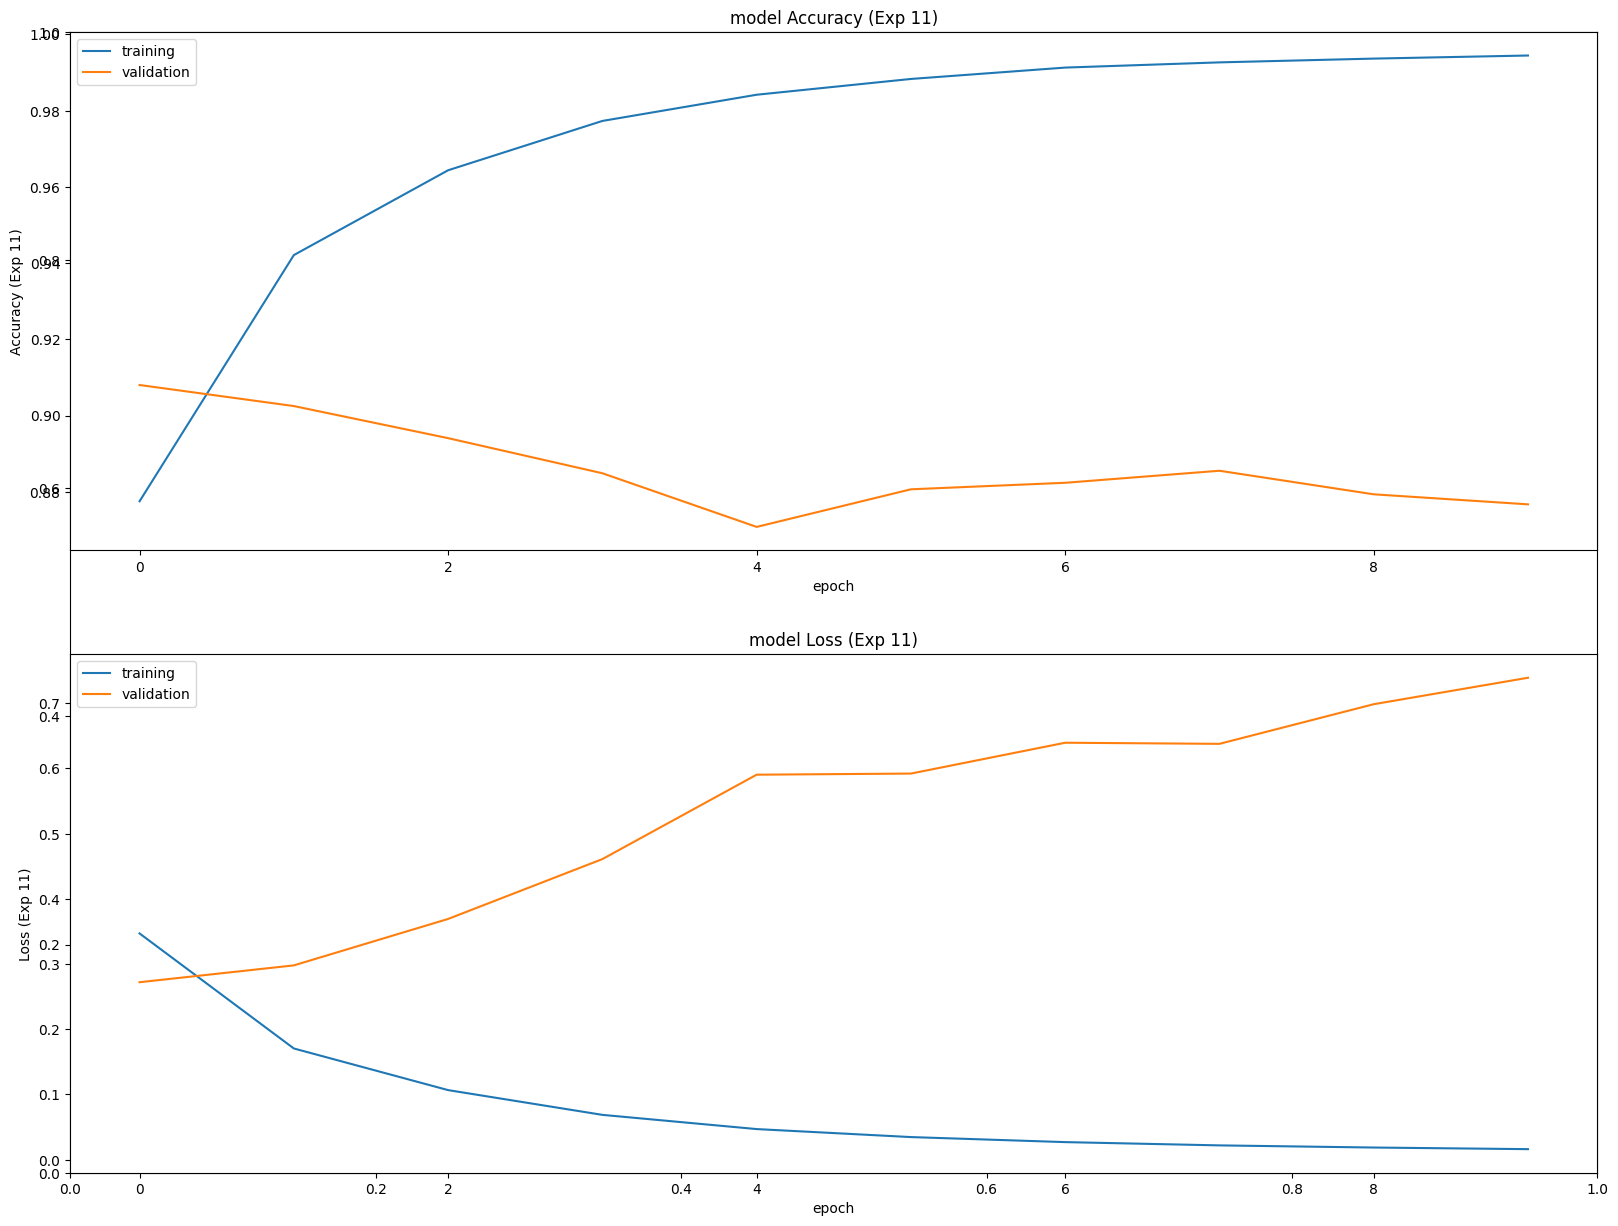

 4/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

2025-08-01 01:20:11.023902: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1900
           1       0.94      0.95      0.95      1900
           2       0.88      0.77      0.82      1900
           3       0.81      0.89      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600

Accuracy Score: 0.8767105263157895
Root Mean Square Error: 0.6031714428532606


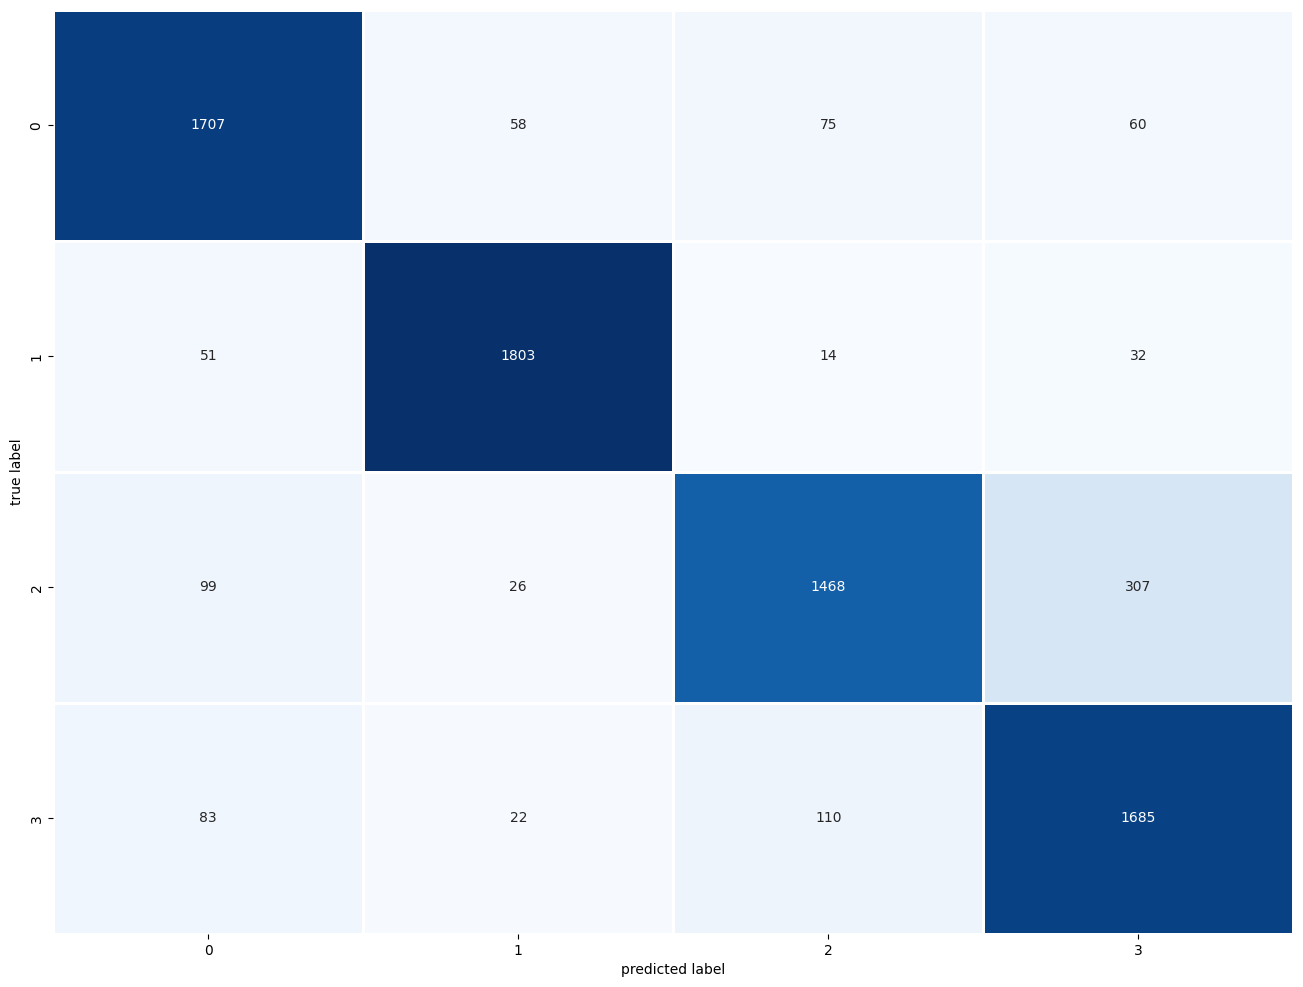

In [29]:
# ======================
# Experiment 11: GRU (Baseline - 128 units)
# ======================
model11 = tf.keras.Sequential([
    layers.Embedding(input_dim=len(text_vectorization.get_vocabulary()),
                     output_dim=128,
                     mask_zero=True),
    layers.GRU(128),
    layers.Dense(n_classes, activation='softmax')
])

model11.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history11 = model11.fit(int_train_ds, validation_data=int_test_ds, epochs=10)

# Metrics & Visualization
history_df11 = pd.DataFrame(history11.history)
plt.subplots(figsize=(16, 12))
plt.tight_layout()
display_training_curves(history_df11['accuracy'], history_df11['val_accuracy'], 'Accuracy (Exp 11)', 211)
display_training_curves(history_df11['loss'], history_df11['val_loss'], 'Loss (Exp 11)', 212)
plt.show()

y_test11 = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes11 = np.argmax(model11.predict(int_test_ds), axis=-1)
print_validation_report(y_test11, pred_classes11)
plot_confusion_matrix(y_test11, pred_classes11)

Experiment 12: GRU (Tweak - Bidirectional GRU)

Epoch 1/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.8160 - loss: 0.4856 - val_accuracy: 0.9136 - val_loss: 0.2608
Epoch 2/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.9389 - loss: 0.1812 - val_accuracy: 0.9072 - val_loss: 0.2971
Epoch 3/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.9618 - loss: 0.1151 - val_accuracy: 0.9025 - val_loss: 0.3498
Epoch 4/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.9761 - loss: 0.0732 - val_accuracy: 0.8966 - val_loss: 0.4274
Epoch 5/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9830 - loss: 0.0515 - val_accuracy: 0.8955 - val_loss: 0.4604
Epoch 6/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.9885 - loss: 0.0350 - val_accuracy: 0.8914 - val_loss: 0.5149
Epoch 7/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.9903 - loss: 0.0289 - val_accuracy: 0.8911 - val_loss: 0.5459
Epoch 8/10
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.9922 -

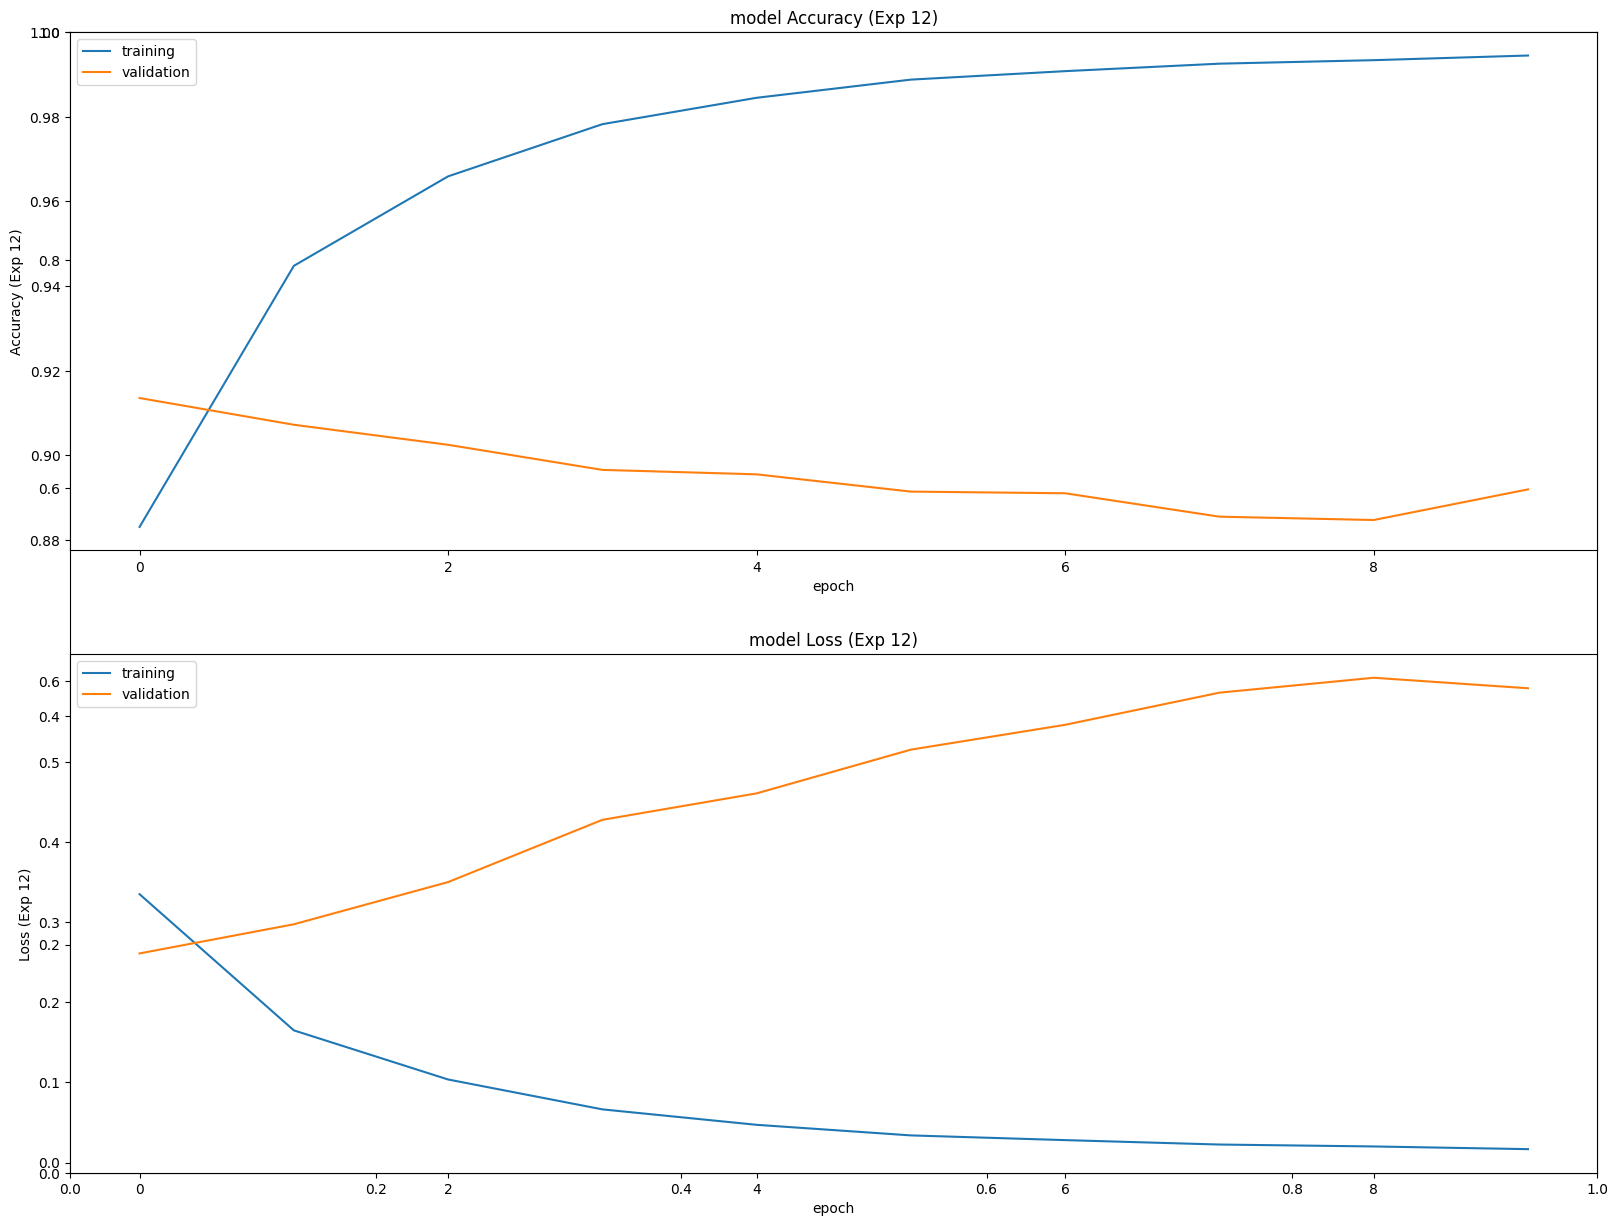

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1900
           1       0.95      0.97      0.96      1900
           2       0.89      0.81      0.85      1900
           3       0.84      0.89      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600

Accuracy Score: 0.8919736842105264
Root Mean Square Error: 0.5793599008706437


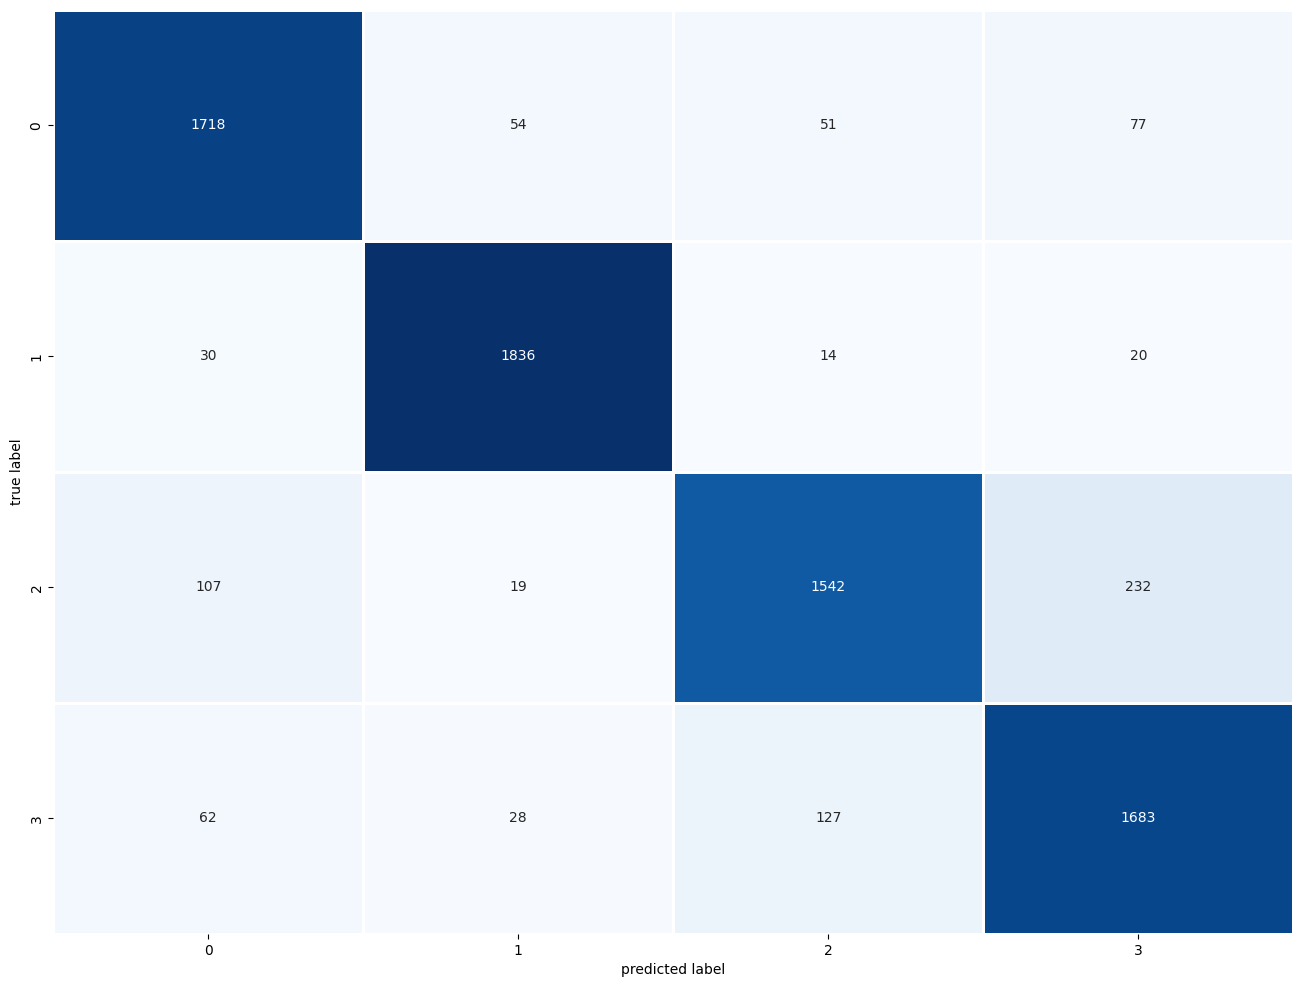

In [30]:
# ======================
# Experiment 12: GRU (Bidirectional - 128 units)
# ======================
model12 = tf.keras.Sequential([
    layers.Embedding(input_dim=len(text_vectorization.get_vocabulary()),
                     output_dim=128,
                     mask_zero=True),
    layers.Bidirectional(layers.GRU(128, dropout=0.3)),
    layers.Dense(n_classes, activation='softmax')
])

model12.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history12 = model12.fit(int_train_ds, validation_data=int_test_ds, epochs=10)

# Metrics & Visualization
history_df12 = pd.DataFrame(history12.history)
plt.subplots(figsize=(16, 12))
plt.tight_layout()
display_training_curves(history_df12['accuracy'], history_df12['val_accuracy'], 'Accuracy (Exp 12)', 211)
display_training_curves(history_df12['loss'], history_df12['val_loss'], 'Loss (Exp 12)', 212)
plt.show()

y_test12 = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes12 = np.argmax(model12.predict(int_test_ds), axis=-1)
print_validation_report(y_test12, pred_classes12)
plot_confusion_matrix(y_test12, pred_classes12)

In [31]:
comparison_df = pd.DataFrame({
    "Experiment": [
        "Exp 2: RNN", "Exp 3: RNN (128 units)", "Exp 4: Stacked RNN", "Exp 5: Bi-RNN",
        "Exp 6: LSTM", "Exp 7: Stacked LSTM", "Exp 8: Bi-LSTM", "Exp 9: LSTM + Drop out",
        "Exp 10: 1D CNN", "Exp 11: GRU", "Exp 12: Bi-GRU"
    ],
    "Val Accuracy": [
        history_df2['val_accuracy'].iloc[-1],
        history_df3['val_accuracy'].iloc[-1],
        history_df4['val_accuracy'].iloc[-1],
        history_df5['val_accuracy'].iloc[-1],
        history_df6['val_accuracy'].iloc[-1],
        history_df7['val_accuracy'].iloc[-1],
        history_df8['val_accuracy'].iloc[-1],
        history_df9['val_accuracy'].iloc[-1],
        history_df10['val_accuracy'].iloc[-1],
        history_df11['val_accuracy'].iloc[-1],
        history_df12['val_accuracy'].iloc[-1],
    ]
})
print(comparison_df)

                Experiment  Val Accuracy
0               Exp 2: RNN      0.866316
1   Exp 3: RNN (128 units)      0.870395
2       Exp 4: Stacked RNN      0.878026
3            Exp 5: Bi-RNN      0.880000
4              Exp 6: LSTM      0.883026
5      Exp 7: Stacked LSTM      0.881053
6           Exp 8: Bi-LSTM      0.888947
7   Exp 9: LSTM + Drop out      0.882237
8           Exp 10: 1D CNN      0.891579
9              Exp 11: GRU      0.876711
10          Exp 12: Bi-GRU      0.891974


In [32]:
import time

# Example: store results for all experiments
results = []

# For each experiment, collect metrics
def record_results(exp_name, history_df, model, test_ds):
    start = time.time()
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    end = time.time()

    results.append({
        "Experiment": exp_name,
        "Train Accuracy": history_df['accuracy'].iloc[-1],
        "Val Accuracy": history_df['val_accuracy'].iloc[-1],
        "Train Loss": history_df['loss'].iloc[-1],
        "Val Loss": history_df['val_loss'].iloc[-1],
        "Test Accuracy": test_acc,
        "Test Loss": test_loss,
        "Process Time (s)": round(end - start, 2)
    })

# Example usage for each model
record_results("Exp 2: RNN", history_df2, model2, int_test_ds)
record_results("Exp 3: RNN (128 units)", history_df3, model3, int_test_ds)
record_results("Exp 4: Stacked RNN", history_df4, model4, int_test_ds)
record_results("Exp 5: Bi-RNN", history_df5, model5, int_test_ds)
record_results("Exp 6: LSTM", history_df6, model6, int_test_ds)
record_results("Exp 7: Stacked LSTM", history_df7, model7, int_test_ds)
record_results("Exp 8: Bi-LSTM", history_df8, model8, int_test_ds)
record_results("Exp 9: LSTM + Dropout", history_df9, model9, int_test_ds)
record_results("Exp 10: 1D CNN", history_df10, model10, int_test_ds)
record_results("Exp 11: GRU", history_df11, model11, int_test_ds)
record_results("Exp 12: Bi-GRU", history_df12, model12, int_test_ds)

# Convert to DataFrame
comparison_df = pd.DataFrame(results)
print(comparison_df)

                Experiment  Train Accuracy  Val Accuracy  Train Loss  \
0               Exp 2: RNN        0.994600      0.866316    0.016161   
1   Exp 3: RNN (128 units)        0.992883      0.870395    0.022389   
2       Exp 4: Stacked RNN        0.991017      0.878026    0.027436   
3            Exp 5: Bi-RNN        0.997133      0.880000    0.009488   
4              Exp 6: LSTM        0.994983      0.883026    0.013537   
5      Exp 7: Stacked LSTM        0.994767      0.881053    0.016352   
6           Exp 8: Bi-LSTM        0.995900      0.888947    0.011963   
7    Exp 9: LSTM + Dropout        0.993867      0.882237    0.018408   
8           Exp 10: 1D CNN        0.996775      0.891579    0.007960   
9              Exp 11: GRU        0.994483      0.876711    0.016114   
10          Exp 12: Bi-GRU        0.994450      0.891974    0.016651   

    Val Loss  Test Accuracy  Test Loss  Process Time (s)  
0   0.710266       0.866316   0.710266              2.35  
1   0.687187     